Dennis Wang

Dataset from https://www.kaggle.com/datasets/samuelotiattakorah/healthcare-no-show-appointment-data

Background on Data:
Information on 100k+ medical appointments from various neighborhoods in Brazil, with the goal of predicting whether or not a patient would show up to their appointment. 


## Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/healthcare_noshows_appointments.csv", dtype={'PatientId': str, 'AppointmentID': str})
#df['PatientId'] = df['PatientId'].astype(int).astype(str)
display(df.head())
display(df.shape)
display(df.info())


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


(106987, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientId       106987 non-null  object
 1   AppointmentID   106987 non-null  object
 2   Gender          106987 non-null  object
 3   ScheduledDay    106987 non-null  object
 4   AppointmentDay  106987 non-null  object
 5   Age             106987 non-null  int64 
 6   Neighbourhood   106987 non-null  object
 7   Scholarship     106987 non-null  bool  
 8   Hipertension    106987 non-null  bool  
 9   Diabetes        106987 non-null  bool  
 10  Alcoholism      106987 non-null  bool  
 11  Handcap         106987 non-null  bool  
 12  SMS_received    106987 non-null  bool  
 13  Showed_up       106987 non-null  bool  
 14  Date.diff       106987 non-null  int64 
dtypes: bool(7), int64(2), object(6)
memory usage: 7.2+ MB


None

Columns names are inconsistent --> Renaming them for ease

In [4]:
df = df.rename(columns={"PatientId": "PatientID", "Showed_up": "ShowedUp", "Date.diff": "DateDiff","Hipertension":"Hypertension", "Handcap":"Handicap"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientID       106987 non-null  object
 1   AppointmentID   106987 non-null  object
 2   Gender          106987 non-null  object
 3   ScheduledDay    106987 non-null  object
 4   AppointmentDay  106987 non-null  object
 5   Age             106987 non-null  int64 
 6   Neighbourhood   106987 non-null  object
 7   Scholarship     106987 non-null  bool  
 8   Hypertension    106987 non-null  bool  
 9   Diabetes        106987 non-null  bool  
 10  Alcoholism      106987 non-null  bool  
 11  Handicap        106987 non-null  bool  
 12  SMS_received    106987 non-null  bool  
 13  ShowedUp        106987 non-null  bool  
 14  DateDiff        106987 non-null  int64 
dtypes: bool(7), int64(2), object(6)
memory usage: 7.2+ MB


It seems a lot of our columns are binary. 

We know each row represents each appointment, but we also need to check if there are patients that occur more than one. If that's the case, then the data isn't iid.

In [5]:
display(len(df['PatientID'].unique()))
display(len(df['AppointmentID'].unique()))

60270

106987

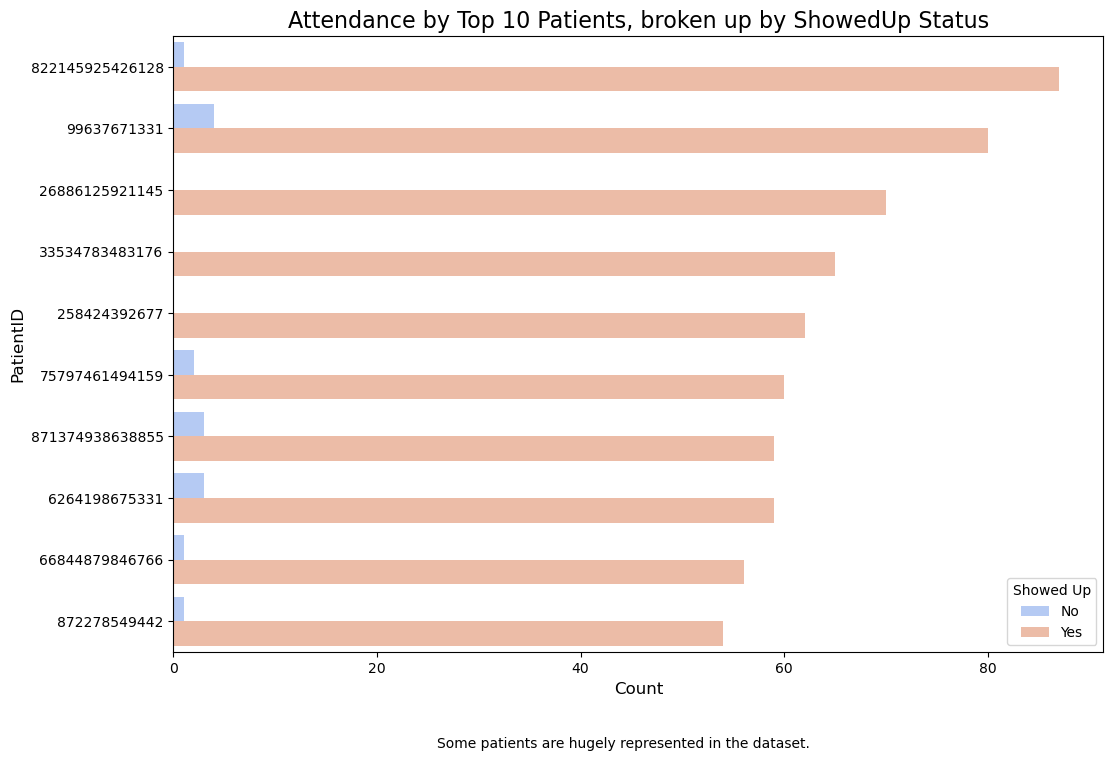

In [149]:
import seaborn as sns
top_neighborhoods = df['PatientID'].value_counts().nlargest(10).index
neighborhood_data = df[df['PatientID'].isin(top_neighborhoods)]

plt.figure(figsize=(12, 8))
sns.countplot(
    y='PatientID',
    hue='ShowedUp',
    data=neighborhood_data,
    order=top_neighborhoods,
    palette='coolwarm'
)
plt.title('Attendance by Top 10 Patients, broken up by ShowedUp Status', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('PatientID', fontsize=12)
plt.legend(title='Showed Up', labels=['No', 'Yes'], fontsize=10)
plt.figtext(0.5, -0.01, "Some patients are hugely represented in the dataset.", wrap = True, horizontalalignment = 'center')
plt.savefig('../figures/showedup_patientids.png', dpi = 300, bbox_inches='tight')
plt.show()

Since some patients appear more than once in the dataset, we will have to stratify by patient when splitting later on.

We'll drop column 'AppointmentID' because we don't need the unique appointment identifier.

In [6]:
df = df.drop(['AppointmentID'], axis=1)

Reordering our columns because I want the target variable 'ShowedUp' to be last, and also for 'DateDiff' to be right after the 'ScheduledDay' and 'AppointmentDay' columns. 'DateDiff' is the number of days between 'ScheduledDay' and 'AppointmentDay' so it makes sense to have them together.

And then creating our X and y variables.

In [7]:
df = df[['PatientID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'DateDiff', 'Age',
       'Neighbourhood', 'Scholarship', 'Hypertension', 'Diabetes',
       'Alcoholism', 'Handicap', 'SMS_received','ShowedUp']]
X = df.iloc[:,:-1]
Y = df.iloc[:,-1:]

#### Visualizing the Target Variable

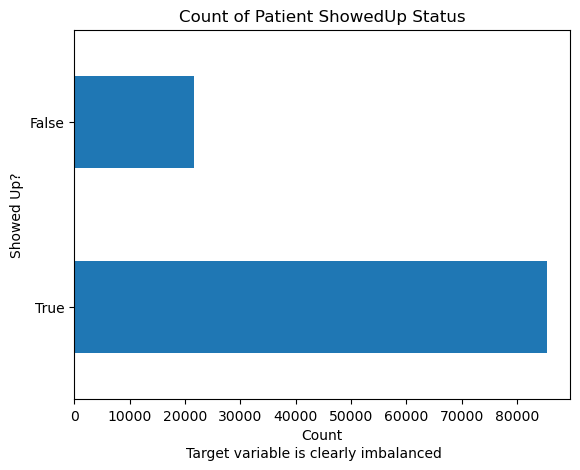

In [8]:
plt.figure()
df['ShowedUp'].value_counts().plot.barh()
plt.xlabel('Count')
plt.ylabel('Showed Up?')
plt.title('Count of Patient ShowedUp Status')
plt.figtext(0.5, -0.01, "Target variable is clearly imbalanced", horizontalalignment = 'center')
plt.savefig('../figures/showedup_count.png', dpi = 300, bbox_inches='tight')
plt.show()

Looks like our categorical target variable, ShowedUp, is highly imbalanced. Thankfully most people show up to their appointment, but we'll have to make sure to stratify when splitting into our train, validation, and test sets later on.

Let's check out our variable DateDiff:

In [9]:
display(df['DateDiff'][df['ShowedUp'] == 1].describe())
(df['DateDiff'][df['ShowedUp'] == 0].describe())

count    85307.000000
mean         8.737794
std         14.558336
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max        179.000000
Name: DateDiff, dtype: float64

count    21680.000000
mean        15.789299
std         16.615843
min         -6.000000
25%          4.000000
50%         10.500000
75%         23.000000
max        179.000000
Name: DateDiff, dtype: float64

DateDiff is very imbalanced. Let's visualize it against ShowedUp status:

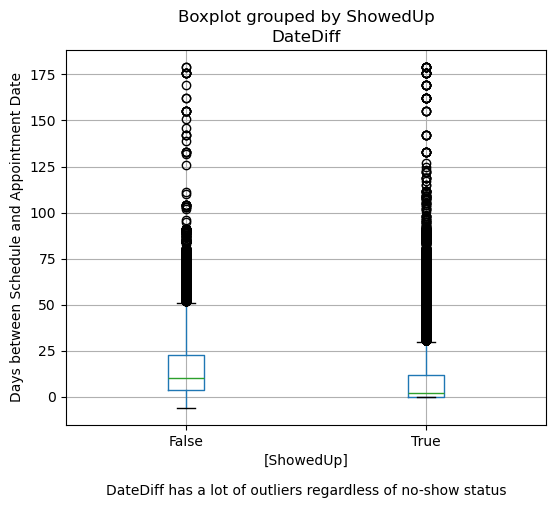

In [10]:
df[['DateDiff','ShowedUp']].boxplot(by='ShowedUp',figsize=(6,5))
plt.ylabel('Days between Schedule and Appointment Date')
plt.figtext(0.5, 0.01, "DateDiff has a lot of outliers regardless of no-show status", horizontalalignment = 'center')
plt.savefig('../figures/showedup_datediff_boxplot.png', dpi = 300, bbox_inches='tight')
plt.show()

A lot of DateDiff outliers regardless of no-show status. We'll probably have to preprocess DateDiff using StandardScaler later on.

Interestingly, we can see that the minimum DateDiff in the false 'ShowedUp' boxplot is actually negative. Maybe it was a clerical error? Or an appointment that was scheduled retroactively for bookkeeping purposes? 

In [152]:
df[df['DateDiff'] < 0]

,PatientID,Gender,ScheduledDay,AppointmentDay,DateDiff,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,ShowedUp,ApptDayOfWeek,ApptMonth,SchedDayOfWeek,SchedMonth
26222,7839272661752,1,2016-05-10,2016-05-09,-1,38,RESISTÊNCIA,False,False,False,False,True,False,False,Monday,May,Tuesday,May
53324,7896293967868,0,2016-05-18,2016-05-17,-1,19,SANTO ANTÔNIO,False,False,False,False,True,False,False,Tuesday,May,Wednesday,May
62055,24252258389979,0,2016-05-05,2016-05-04,-1,22,CONSOLAÇÃO,False,False,False,False,False,False,False,Wednesday,May,Thursday,May
69225,998231581612122,0,2016-05-11,2016-05-05,-6,81,SANTO ANTÔNIO,False,False,False,False,False,False,False,Thursday,May,Wednesday,May
70039,3787481966821,1,2016-05-04,2016-05-03,-1,7,TABUAZEIRO,False,False,False,False,False,False,False,Tuesday,May,Wednesday,May


I want to see how the proportion of No Shows changes with increasing DateDiff.

In [11]:
df2 = df[df['ShowedUp'] == False].groupby("DateDiff").count().reset_index()[['DateDiff', 'ShowedUp']].rename(columns = {"DateDiff":"DateDiff", "ShowedUp":"No Shows"}).set_index(['DateDiff'])
df3 = df.groupby("DateDiff").count().reset_index()[['DateDiff', 'ShowedUp']].rename(columns = {"DateDiff":"DateDiff", "ShowedUp":"TotalCount"}).set_index(['DateDiff'])

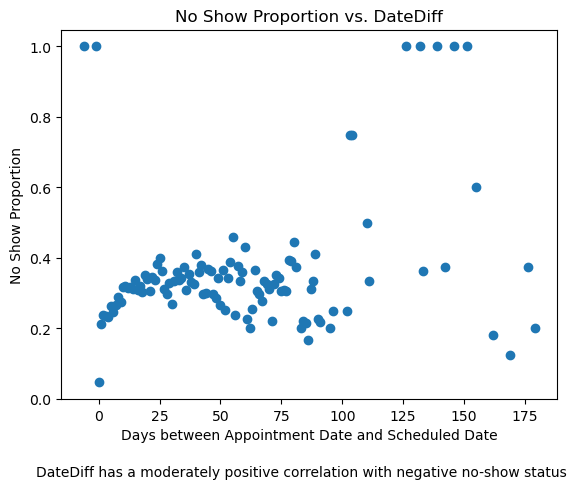

In [12]:
#pd.concat([df2, df3], axis=1)
df23 = df2.merge(df3, on='DateDiff', how='outer')
df23['NoShow_Prop'] = df23['No Shows'] / df23['TotalCount']
df23 = df23.reset_index()

plt.scatter(df23['DateDiff'], df23['NoShow_Prop'])
plt.xlabel("Days between Appointment Date and Scheduled Date")
plt.ylabel("No Show Proportion")
plt.title("No Show Proportion vs. DateDiff")
plt.figtext(0.5, -0.05, "DateDiff has a moderately positive correlation with negative no-show status", horizontalalignment = 'center')
plt.savefig('../figures/datediff_noshowprop.png', dpi = 300, bbox_inches='tight')
plt.show()

It does seem that there's an initial strong correlation that as the DateDiff increases, so does the proportion of No Shows. However, after ~30 days, this correlation weakens considerably and instead the variance of No Show Proportion increases dramatically.

Another explanatory variable of interest is 'SMS_received', which indicates whether or not a patient was sent one or more ahead of their appointment to remind them of it. We visualize it against our target variable below:

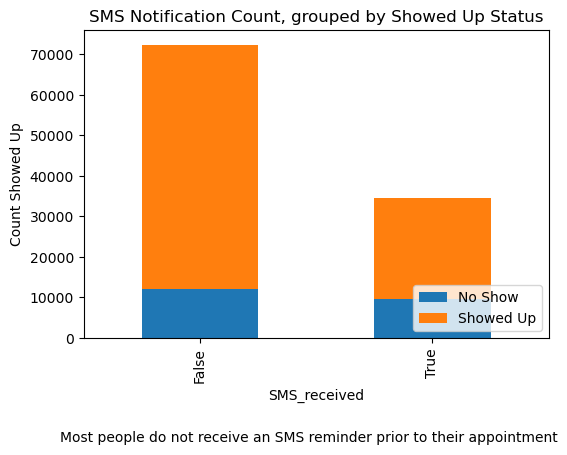

In [162]:
fig, ax = plt.subplots(figsize=(6,4))
p = df.groupby(['SMS_received', 'ShowedUp']).size().unstack().plot.bar(stacked=True, figsize=(6,4), ax=ax)
plt.ylabel('Count Showed Up')
plt.legend(["No Show", "Showed Up"],loc=4)
plt.title("SMS Notification Count, grouped by Showed Up Status")
plt.figtext(0.5, -0.15, "Most people do not receive an SMS reminder prior to their appointment", horizontalalignment = 'center')
plt.savefig('../figures/showedup_sms.png', dpi = 300, bbox_inches='tight')
plt.show()

Interestingly, the vast majority of the patients in the dataset (approximately two-thirds it seems) don't receive any sort of notification reminder ahead of their appointment. Perhaps increased this number, we would see a reduction in no-shows? Let's try visualizing the SMS_received vs. ShowedUp again, but normalized this time:

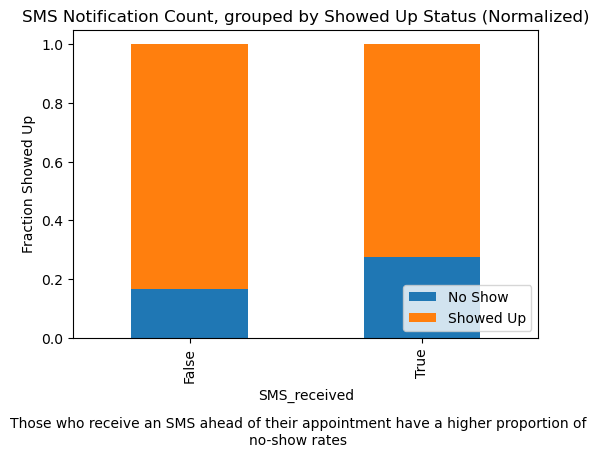

In [163]:
fig, ax = plt.subplots(figsize=(6,4))
count_matrix = df.groupby(['SMS_received', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(6,4), ax=ax)
plt.ylabel('Fraction Showed Up')
plt.title("SMS Notification Count, grouped by Showed Up Status (Normalized)")
plt.legend(["No Show", "Showed Up"],loc=4)
plt.figtext(0.5, -0.15, "Those who receive an SMS ahead of their appointment have a higher proportion of no-show rates", horizontalalignment = 'center', wrap = True)
plt.savefig('../figures/showedup_sms_normalized.png', dpi = 300, bbox_inches='tight')
plt.show()

Surprisingly, and against my earlier belief, it seems that the group of patients that received an SMS ahead of their appointment actually have higher no-show rates, at least in this dataset.

Let's visualize Gender vs. ShowedUp:

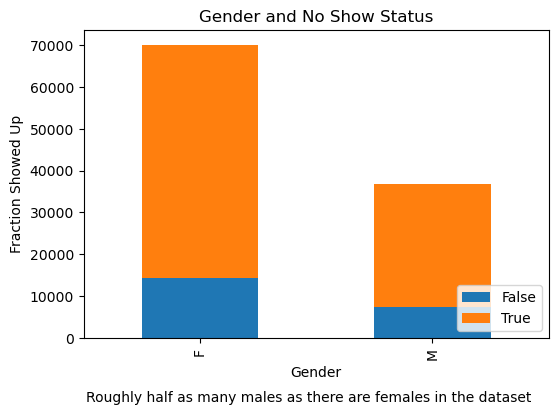

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
p = df.groupby(['Gender', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.ylabel('Fraction Showed Up')
plt.legend(loc=4)
plt.title("Gender and No Show Status")
plt.figtext(0.5, -0.05, "Roughly half as many males as there are females in the dataset", horizontalalignment = 'center', wrap = True)
plt.savefig('../figures/showedup_gender', dpi = 300, bbox_inches='tight')
plt.show()


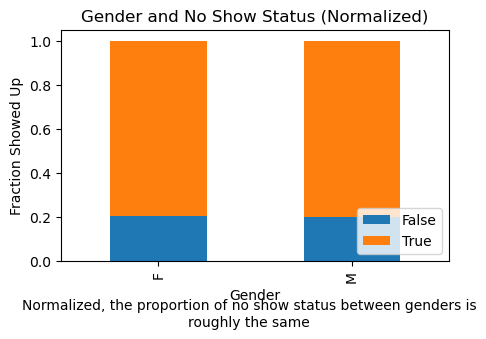

In [16]:
count_matrix = df.groupby(['Gender', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.figtext(0.5, -0.1, "Normalized, the proportion of no show status between genders is roughly the same", horizontalalignment = 'center', wrap = True)
plt.title("Gender and No Show Status (Normalized)")
plt.ylabel('Fraction Showed Up')
plt.savefig('../figures/showedup_gender_normalized', dpi = 300, bbox_inches='tight')
plt.legend(loc=4)
plt.show()

There are twice as many Females as Males in our dataset, but after normalization, their No Show rates are approximately the same, so I don't anticipate Gender to be a strong predictor in our model.

How about neighborhood though? There are approximately 80 unique neighborhoods in our dataset, so let's just normalize the top 10.

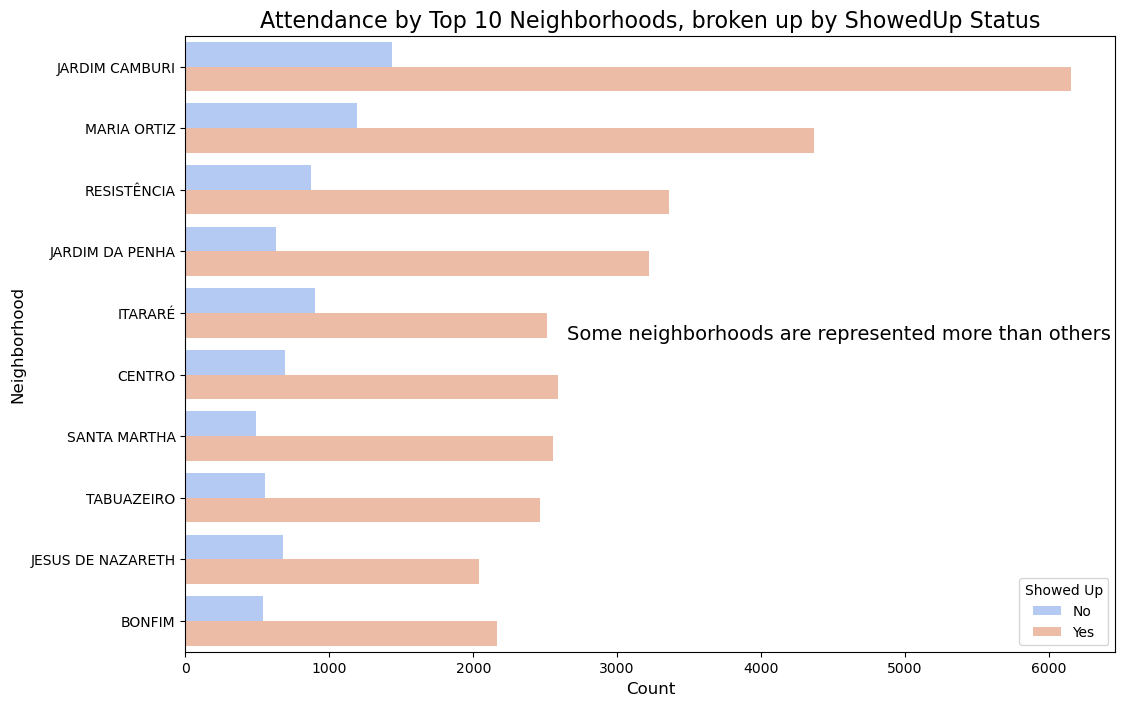

In [17]:
import seaborn as sns
top_neighborhoods = df['Neighbourhood'].value_counts().nlargest(10).index
neighborhood_data = df[df['Neighbourhood'].isin(top_neighborhoods)]

plt.figure(figsize=(12, 8))
sns.countplot(
    y='Neighbourhood',
    hue='ShowedUp',
    data=neighborhood_data,
    order=top_neighborhoods,
    palette='coolwarm'
)
plt.title('Attendance by Top 10 Neighborhoods, broken up by ShowedUp Status', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.legend(title='Showed Up', labels=['No', 'Yes'], fontsize=10)
plt.figtext(0.67, 0.5, "Some neighborhoods are represented more than others", horizontalalignment = 'center', wrap = True, fontsize=14)
plt.savefig('../figures/showedup_neighborhoods.png', dpi = 300, bbox_inches='tight')
plt.show()

Looks like there's definitely more representation from some neighbourhoods compared to others, such as Jardim Camburi, Maria Ortiz, and Resistencia. But are any of these actually correlated with our target variable? Let's try normalizing the plot:

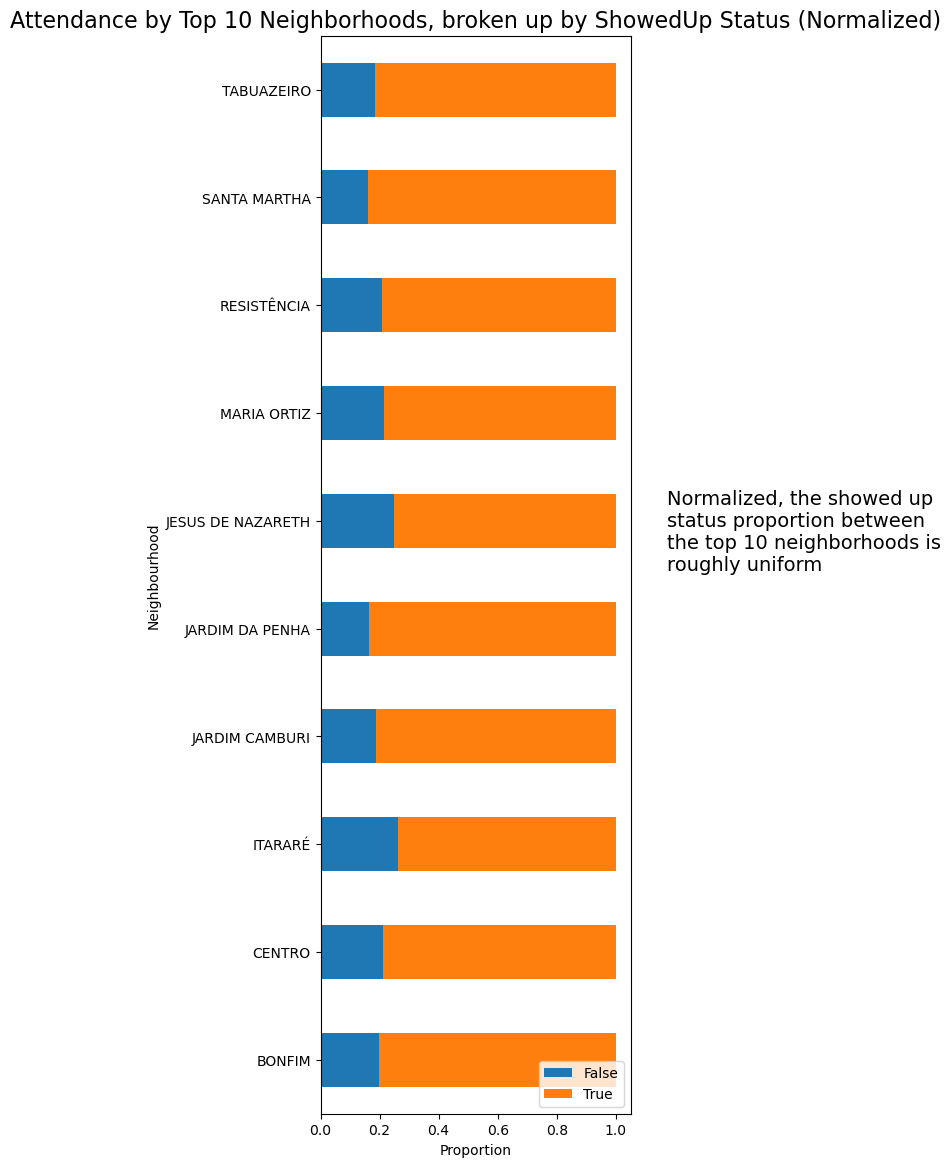

In [18]:
count_matrix = neighborhood_data.groupby(['Neighbourhood', 'ShowedUp']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='barh', stacked=True,figsize=(4,14))
plt.legend(loc=4)
plt.title('Attendance by Top 10 Neighborhoods, broken up by ShowedUp Status (Normalized)', fontsize=16)
plt.xlabel("Proportion")
plt.figtext(0.99, 0.5, "Normalized, the showed up status proportion between the top 10 neighborhoods is roughly uniform", wrap = True, fontsize=14)
plt.savefig('../figures/showedup_neighborhoods_normalized.png', dpi = 300, bbox_inches='tight')
plt.show()

The normalized plot seems fairly uniform in ShowedUp status proportion. I don't anticipate the Neighborhoods to be a strong predictor in our model.

In [19]:
df.loc[:, df.isnull().any() ]

""
0
1
2
3
4
...
106982
106983
106984
106985


No missing values in our dataset.

#### Testing relationships between our features and target variable

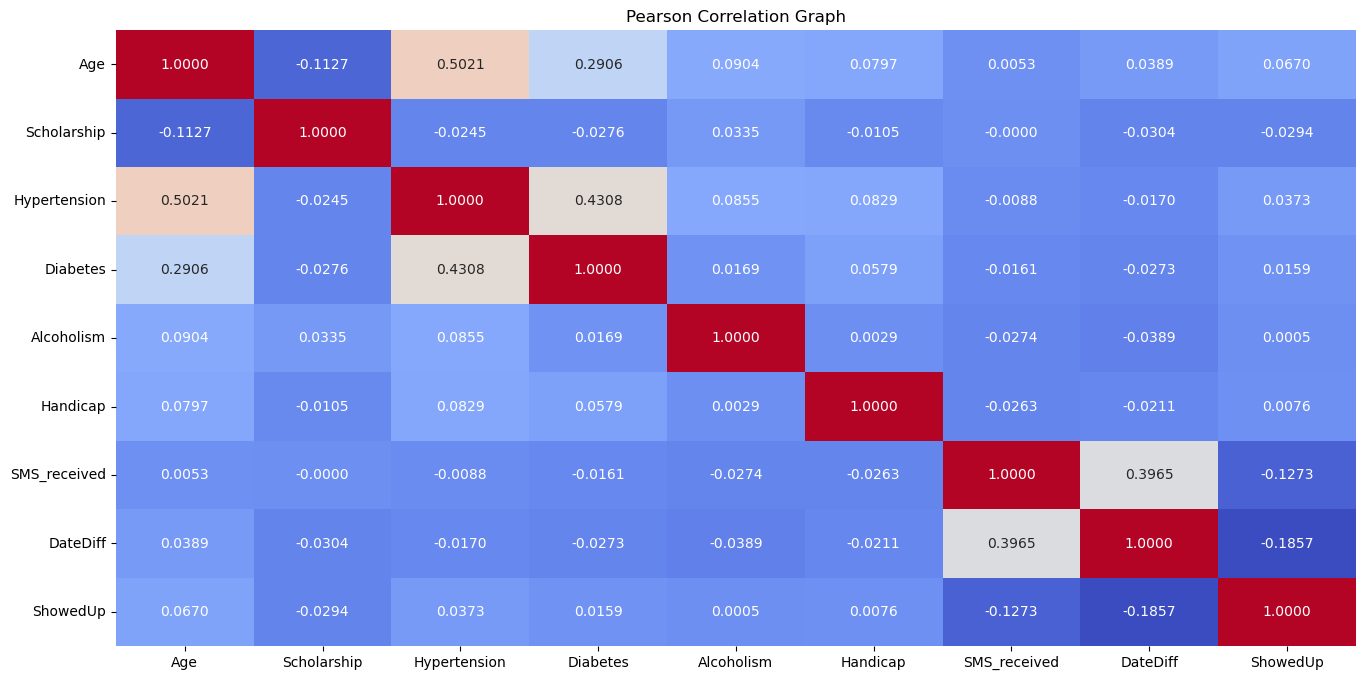

In [20]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
df_num = df[['Age','Scholarship','Hypertension','Diabetes','Alcoholism','Handicap','SMS_received', 'DateDiff', 'ShowedUp']]
fig, ax = plt.subplots(figsize = (16,8))
sns.heatmap(df_num.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.set_title("Pearson Correlation Graph")
fig.savefig('../figures/pearson_corr.png',dpi = 300, bbox_inches='tight')
plt.show()

Not that much correlation between our numerical features. Between our explanatory features and target variable, the strongest relationship lies between DateDiff and ShowedUp. Between strictly our explanatory features, we can see that Hypertension is somewhat correlated with Age and Diabetes.

How about linear correlations between our features and the target variable?

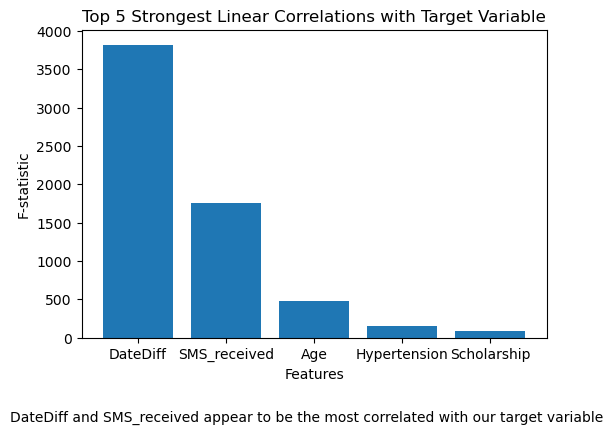

In [21]:
from sklearn.feature_selection import f_regression

X_nums = df_num.drop(['ShowedUp'], axis=1)
Y_nums = np.ravel(df_num.iloc[:,-1:])

f_statistic, p_values = f_regression(X_nums, Y_nums)

cols = X_nums.columns
f_df = pd.DataFrame(data = f_statistic, index = cols).sort_values(by=0, ascending = False).head(5)

plt.figure(figsize=(6,4))
plt.bar(x=f_df.index, height = f_df[0])
plt.title('Top 5 Strongest Linear Correlations with Target Variable')
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.figtext(0.5, -0.1, "DateDiff and SMS_received appear to be the most correlated with our target variable", horizontalalignment = 'center', wrap = True)
plt.savefig('../figures/linear_corr.png',dpi = 300, bbox_inches='tight')
plt.show()

How about non-linear correlations? i.e. mutual information

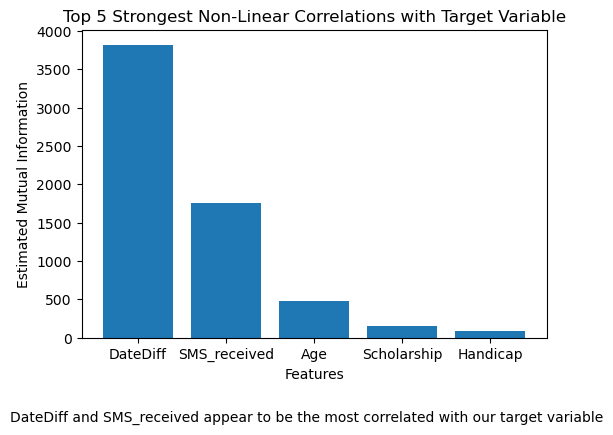

In [22]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X_nums, Y_nums)

cols = X_nums.columns
mi_df = pd.DataFrame(data = mi, index = cols).sort_values(by=0, ascending = False).head(5)

plt.figure(figsize=(6,4))
plt.bar(x=mi_df.index, height = f_df[0])
plt.title('Top 5 Strongest Non-Linear Correlations with Target Variable')
plt.xlabel('Features')
plt.ylabel('Estimated Mutual Information')
plt.figtext(0.5, -0.1, "DateDiff and SMS_received appear to be the most correlated with our target variable", horizontalalignment = 'center', wrap = True)
plt.savefig('../figures/nonlinear_corr.png',dpi = 300, bbox_inches='tight')
plt.show()

Both plots look similar, with DateDiff and SMS_received being our features most correlated with the target variable, ShowedUp. This aligns with our pearson correlation plot.

#### Converting Gender Strings 'M' and 'F' to 0 and 1

In [23]:
df = df.replace({'Gender':{'M':1, 'F':0}})

C:\Users\DWang\AppData\Local\Temp\ipykernel_15372\882688251.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Gender':{'M':1, 'F':0}})


#### Feature Engineer Day of Week columns + month columns from ScheduledDay and AppointmentDay
Since some of our patients occur more than once in our dataset, their column information would be pretty much identical between appointments, save for the ScheduledDay, AppointmentDay, and DateDiff columns. Feature engineering some new variables from ScheduledDay and AppointmentDay could be another way to further differentiate those rows.

In [24]:
df['ApptDayOfWeek'] = pd.to_datetime(df['AppointmentDay']).dt.day_name()
df['ApptMonth'] = pd.to_datetime(df['AppointmentDay']).dt.month_name()

df['SchedDayOfWeek'] = pd.to_datetime(df['ScheduledDay']).dt.day_name()
df['SchedMonth'] = pd.to_datetime(df['ScheduledDay']).dt.month_name()

Let's visualize our 4 new columns:

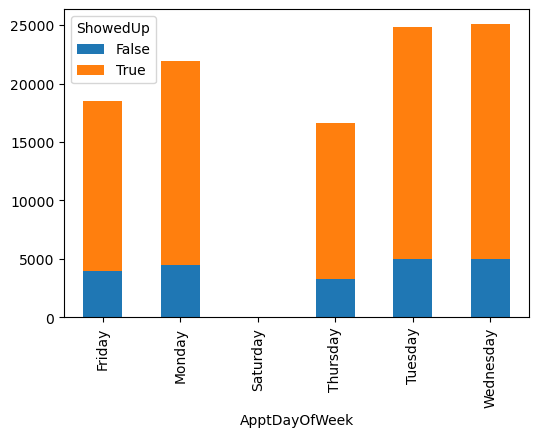

In [25]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['ApptDayOfWeek', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

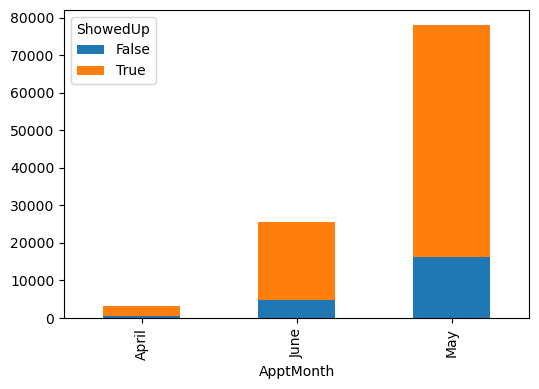

In [26]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['ApptMonth', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

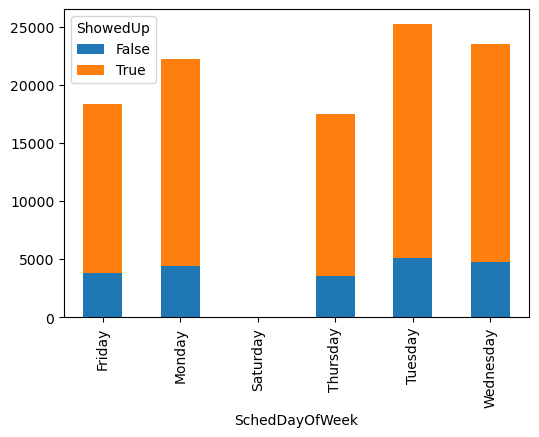

In [27]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['SchedDayOfWeek', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

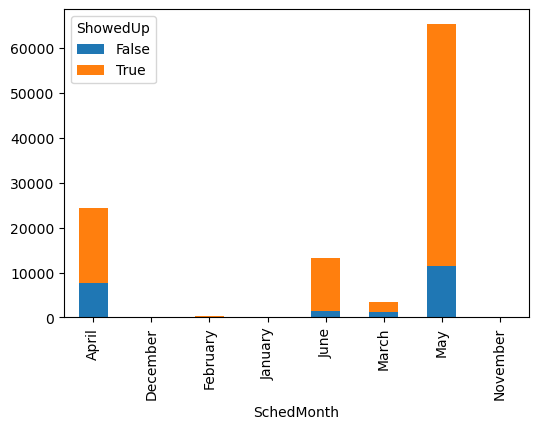

In [28]:
fig, ax = plt.subplots(figsize = (6,4))
p = df.groupby(['SchedMonth', 'ShowedUp']).size().unstack().plot.bar(stacked=True, ax=ax)
plt.show()

In [29]:
np.unique(df['SchedMonth'])

array(['April', 'December', 'February', 'January', 'June', 'March', 'May',
       'November'], dtype=object)

Interesting that the vast majority of Appointments are both scheduled during and for the Spring months. There are definitely values for other months of the year, but they barely appear in the plots.

### Splitting Data

> Describe briefly how you split the data and why.

We have two main concerns to address in our splitting strategy:
1. making sure patients stay within their splits, i.e. preventing data leakage via grouping.
2. making sure our imbalanced target variable is properly distributed across our splits, i.e. stratifying

Therefore we'll use two rounds of StratifiedGroupKFold:
1. 1st split to split into X_other and X_test
2. 2nd split to split into X_train and X_val

Given we have ~100k rows, we'll use n_splits = 5 to have 4 folds for X_other, and 1 fold for X_test (4:1) This means X_other will have approximately 80k rows and X_test will have 20k rows. We'll further split X_other using n_splits = 4 (3:1) so that X_train will have roughly 60k rows and X_val will have roughly 20k rows. As a result, we'll achieve our 60:20:20 train:validation:test size ratio.

We will be creating our test set for evaluating how our model performs on previously unseen data later. We will have to repeat the data under the second round of splitting again for when we're training our models and cross-validating them. But, for now we'll leave it in here to prove that this splitting strategy achieves our goals:

In [30]:
from sklearn.model_selection import StratifiedGroupKFold
random_state = 1030
# Dropping these columns since we can't use them in our model.
X = df.drop(['ShowedUp', 'ScheduledDay', 'AppointmentDay'], axis=1)
y = df['ShowedUp']
groups = df['PatientID']

sgkf = StratifiedGroupKFold(n_splits=5, random_state=1030, shuffle=True)

# 1st split - split train+val and test sets
for trainval_index, test_index in sgkf.split(X, y, groups=groups):
    X_trainval, X_test = X.iloc[trainval_index], X.iloc[test_index]
    y_trainval, y_test = y.iloc[trainval_index], y.iloc[test_index]
    groups_trainval = groups.iloc[trainval_index]

# Will have to repeat this part when training our models
sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=1030, shuffle=True)
# 2nd split - splitting trainval into training and validation sets
for train_index, val_index in sgkf_2.split(X_trainval, y_trainval, groups = groups_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

Let's show that our splitting strategy worked so that we've achieved:
1. Roughly 60:20:20 train:val:test sizes
2. Stratification preserves class imbalances across datasets
3. No data leakage regarding PatientId groups

In [31]:
for key, value in {"X":X, "X_train":X_train, "X_val": X_val, "X_test":X_test}.items():
    print(f'{key} rows: \t{value.shape[0]}')
print("Splits are roughly 60:20:20 sizes")

X rows: 	106987
X_train rows: 	63853
X_val rows: 	21810
X_test rows: 	21324
Splits are roughly 60:20:20 sizes


In [32]:
def getProp(df):
    num = df[df == False].count()
    denom = df.count()
    return num / denom
print(f"No Show Status proportion\n{getProp(y_train)}\n{getProp(y_val)}\n{getProp(y_test)}")

No Show Status proportion
0.20332639030272656
0.20829894543787253
0.19480397673982366


In [33]:
a = X_train['PatientID']
b = X_val['PatientID']
c = X_test['PatientID']
print(list(set(a) & set(b) & set(c)))
print("No overlap in PatientID between groups")

[]
No overlap in PatientID between groups


In [34]:
X_val.columns

Index(['PatientID', 'Gender', 'DateDiff', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap',
       'SMS_received', 'ApptDayOfWeek', 'ApptMonth', 'SchedDayOfWeek',
       'SchedMonth'],
      dtype='object')

In [35]:
# Dropping PatientID in all of our sets now that we don't need it anymore:
pd.options.mode.chained_assignment = None  # default='warn'
drop_patid = lambda xset: xset.drop("PatientID", axis = 1, inplace = True)
for i in [X_train, X_val, X_test, X_trainval]: drop_patid(i)

### Preprocessing the Data

>What preprocessors did you use and why? 
>
>How many features and data points do you have before and after preprocessing. 
>
>If you have missing values, describe the basic properties of the missing values (e.g., what fraction of the points have missing values, which features, what fraction of the features are missing, etc).

#### Use a Pipeline for the following:
- normalize Age (MinMax Scaler)
- standardize DateDiff (StandardScaler)
- one hot encode neighbourhood (81 unique values)
- one hot encode:
    - ApptDayOfWeek
    - SchedDayOfWeek
    - ApptMonth
    - SchedMonth

Minmax scale age since the range of values that an age could possibly take are fairly predictable. The same cannot be said for DateDiff (given all the outliers in our boxplot), so I'm applying StandardScaler to that.

I will one hot encode neighborhood which has 81 different and unique neighborhoods. This will create a lot of columns.

I will also ordinal encode the DaysOfWeek or Month columns since there's a definitive "order" to them.

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn import set_config
ordinal_ftrs = ['ApptDayOfWeek', 'SchedDayOfWeek', 'ApptMonth', 'SchedMonth'] 
# sunday doesn't show up in DayOfWeek columns\n",
ordinal_cats = [['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                ['January', 'February', 'March', 'April', 'May', 'June', 'July' ,'August', 'September', 'October', 'November', 'December'],
                ['January', 'February', 'March', 'April', 'May', 'June', 'July' ,'August', 'September', 'October', 'November', 'December']]
onehot_ftrs = ['Neighbourhood']
minmax_ftrs = ['remainder__Age']
std_ftrs = ['remainder__DateDiff']

X = df.drop(['ShowedUp', 'ScheduledDay', 'AppointmentDay', 'PatientID'], axis=1)
y = df['ShowedUp']
y = (1-y).astype(bool) #invert y so that no-show status is class 1 instead of 0
groups = df['PatientID']

set_config(transform_output="pandas")
# collect all the categorical encoders
# Need to process these first on the entire dataset in case some values don't appear in certain folds
first_preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs)]
        , remainder = 'passthrough')
first_prep = Pipeline(steps=[('preprocessor', first_preprocessor)])
X_firstprep = first_prep.fit_transform(X)         

sgkf = StratifiedGroupKFold(n_splits=5, random_state=1030, shuffle=True)
sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=1030, shuffle=True)
# 1st split
for trainval_index, test_index in sgkf.split(X_firstprep, y, groups=groups):
    X_trainval, X_test = X_firstprep.iloc[trainval_index], X_firstprep.iloc[test_index]
    y_trainval, y_test = y.iloc[trainval_index], y.iloc[test_index]
    groups_trainval = groups.iloc[trainval_index]
sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=1030, shuffle=True)
# 2nd split - splitting trainval into training and validation sets
for train_index, val_index in sgkf_2.split(X_trainval, y_trainval, groups = groups_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

# and then our numerical preprocessors, which will be applied to each dataset to prevent data leakage
preprocessor = ColumnTransformer(
    transformers=[
        #('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        #('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)]
        , remainder = 'passthrough')
# standardize all features after preprocessing
prep = Pipeline(steps=[('preprocessor', preprocessor), ('std', StandardScaler())]) # for now we only preprocess 
                                                       # later on we will add other steps here

X_trainval_prep = prep.fit_transform(X_trainval)
X_train_prep = prep.fit_transform(X_train)
X_val_prep = prep.transform(X_val)
X_test_prep = prep.transform(X_test)                

print(X_trainval.shape)
print(X_train.shape)
print(X_train_prep.shape)
#print(X_train_prep)
print(X_val.shape)
print(X_val_prep.shape)
print(X_test.shape)
print(X_test_prep.shape)

(85663, 94)
(63853, 94)
(63853, 94)
(21810, 94)
(21810, 94)
(21324, 94)
(21324, 94)


Check the results of our Preprocessing

In [37]:
[i for i in X_train_prep.columns]

['minmax__remainder__Age',
 'std__remainder__DateDiff',
 'remainder__ord__ApptDayOfWeek',
 'remainder__ord__SchedDayOfWeek',
 'remainder__ord__ApptMonth',
 'remainder__ord__SchedMonth',
 'remainder__onehot__Neighbourhood_AEROPORTO',
 'remainder__onehot__Neighbourhood_ANDORINHAS',
 'remainder__onehot__Neighbourhood_ANTÔNIO HONÓRIO',
 'remainder__onehot__Neighbourhood_ARIOVALDO FAVALESSA',
 'remainder__onehot__Neighbourhood_BARRO VERMELHO',
 'remainder__onehot__Neighbourhood_BELA VISTA',
 'remainder__onehot__Neighbourhood_BENTO FERREIRA',
 'remainder__onehot__Neighbourhood_BOA VISTA',
 'remainder__onehot__Neighbourhood_BONFIM',
 'remainder__onehot__Neighbourhood_CARATOÍRA',
 'remainder__onehot__Neighbourhood_CENTRO',
 'remainder__onehot__Neighbourhood_COMDUSA',
 'remainder__onehot__Neighbourhood_CONQUISTA',
 'remainder__onehot__Neighbourhood_CONSOLAÇÃO',
 'remainder__onehot__Neighbourhood_CRUZAMENTO',
 'remainder__onehot__Neighbourhood_DA PENHA',
 'remainder__onehot__Neighbourhood_DE LOU

Turn the first split into a function because we'll need to do it again during our model building, many times.

In [38]:
def trainval_test(X, y, random_state):
    sgkf = StratifiedGroupKFold(n_splits=5, random_state=random_state, shuffle=True)
    # 1st split
    for trainval_index, test_index in sgkf.split(X, y, groups=groups):
        X_trainval, X_test = X_firstprep.iloc[trainval_index], X_firstprep.iloc[test_index]
        y_trainval, y_test = y.iloc[trainval_index], y.iloc[test_index]
        groups_trainval = groups.iloc[trainval_index]

    return X_trainval, X_test, y_trainval, y_test, groups_trainval
X_trainval, X_test, y_trainval, y_test, groups_trainval = trainval_test(X_firstprep, y, 1030)

### Evaluation Metric:

We will need to consider the baseline, which is the result of predicting the majority  (False of ShowedUp status) for every point.

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
y_pred_base = np.full(len(y_test), False)
base_accuracy = accuracy_score(y_test, y_pred_base)
base_p = precision_score(y_test, y_pred_base, zero_division=0)
base_r = recall_score(y_test, y_pred_base)
base_f1 = fbeta_score(y_test, y_pred_base, beta=1)
display(base_accuracy, base_p, base_r, base_f1)

0.8051960232601764

0.0

0.0

0.0

The baseline accuracy is 80.5%. Since the dataset is heavily imbalanced, we can consider the following metrics that don't use the True Negative Rate:
- average_precision_score
- f score (beta = 1)
- precision-recall curve
- logloss

Do we prioritize minimizing FP's or FN's? The "cost" of predicting wrong is not particularly huge, so we can just stick with beta = 1 for our F-score.

### Choosing our Machine Learning Algorithm

 Try at least four different ML algorithms we covered in class1 on your dataset and at least two of those models should be non-linear. Describe what parameters you tune and the values you try.

 Measure the uncertainties of your evaluation metric due to splitting and due to non-deterministic ML methods (e.g., random forest). In general, explain what considerations went into each step of the pipeline

- Logistic Regression
- KNN (no weight_class)
- XGBoost
- Random Forest
- SVC

In [49]:
#TODO: look at hyperparameter tuning.ipynb for how to do GridSearchCV with kfold cv
#TODO: Get scores per model and per random state
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
# look at gridsearchcv and ps7
nr_states = 5
final_models = []

for i in range(nr_states):
    print(f"Random State {i}")
    # Creating trainval and test sets
    X_trainval, X_test, y_trainval, y_test, groups_trainval = trainval_test(X_firstprep, y, i)
    
    sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=i, shuffle=True)
    # 2nd split - splitting trainval into training and validation sets
    models = [
        LogisticRegression(random_state=i, solver = 'saga', max_iter = 1000000),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=i),
        
    ]
    # and our lists of parameters, GridSearchCV will loop through all combos
    param_list = [
        { #LogisticRegression
            'model__class_weight': [None, 'balanced'],
            'model__penalty': ['l1','l2'], #'elasticnet', None
            'model__C':np.logspace(-2,2,13), #inverse of alpha
        },
        { #KNN
            'model__n_neighbors': [1, 3, 5, 10, 20, 30],
            'model__weights': ['uniform','distance',None]
        },
        { #RandomForestClassifier
            'model__class_weight': [None, 'balanced'],
            'model__max_depth': [1, 3, 5, 10, 30, 100], # the max_depth should be smaller or equal than the number of features roughly
            'model__max_features': ['sqrt', 'log2', 0.3, 0.5], # linearly spaced between 0.5 and 1
        }
    ]
    # for each Model...
    # Create a new Pipeline with our previous ColumnTransformer + new model
    for j in range(len(models)):
        start_time = time.time()
        print(f"\nModel {models[j]}")
        clf = Pipeline(steps=[
            ('preprocessor', preprocessor)
            , ('std', StandardScaler())
            , ('model', models[j])]
            )
        grid = GridSearchCV(estimator = clf, param_grid = param_list[j], scoring='f1',  #'f1', 'average_precision', balanced_accuracy\
                    cv = sgkf_2, return_train_score=True, n_jobs = -1)
        grid.fit(X = X_trainval, y = y_trainval, groups = groups_trainval)
        # save results into a data frame. feel free to print it and inspect it
        
        # save the model + results, if it's the best in the current random state
        # calculate and save the test score
        y_test_pred = grid.predict(X_test)
        current_acc = accuracy_score(y_test,y_test_pred)
        current_p = precision_score(y_test,y_test_pred)
        current_r = recall_score(y_test,y_test_pred)
        current_f1 = f1_score(y_test,y_test_pred)
        
        final_models.append({
            'random_state': i,
            'grid': grid,
            'model':grid.best_estimator_['model'],
            'val_score': grid.best_score_,
            'test_accuracy':current_acc,
            'test_p': current_p,
            'test_r': current_r,
            'test_f1': current_f1
        })

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        print('accuracy_score: ', current_acc)
        print('precision score: ', current_p)
        print('recall score: ', current_r)
        print('f1 score: ', current_f1)
        print(f"Model Total Runtime: {round(time.time() - start_time, 3)}")
models_df = pd.DataFrame(final_models)

Random State 0

Model LogisticRegression(max_iter=1000000, random_state=0, solver='saga')
best model parameters: {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__penalty': 'l1'}
validation score: 0.4044245347809349
accuracy_score:  0.6584497141250352
precision score:  0.31654942613846726
recall score:  0.5944380069524913
f1 score:  0.4131100016105653
Model Total Runtime: 160.327

Model KNeighborsClassifier()
best model parameters: {'model__n_neighbors': 1, 'model__weights': 'uniform'}
validation score: 0.2977816356088519
accuracy_score:  0.7263567344643359
precision score:  0.3105420188960716
recall score:  0.28945538818076477
f1 score:  0.2996281636080125
Model Total Runtime: 209.447

Model RandomForestClassifier(random_state=0)
best model parameters: {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__max_features': 0.5}
validation score: 0.4494518359905913
accuracy_score:  0.5948073858843378
precision score:  0.3071511265473328
recall score:  0.799304750

In [54]:
# SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# subsample because SVC is taking too long training on the full training set
sample_size = 0.20
nr_states = 5
svc_models = []

params = { #SVC
            'model__class_weight': [None, 'balanced'],
            'model__C': np.logspace(-3,3,num=7),
            'model__gamma': np.logspace(-4,2,num=4)
        }

for i in range(nr_states):
    start_time = time.time()
    print(f"Random State {i}")
    print("Creating trainval and test sets...")
    # Creating trainval and test sets
    X_trainval, X_test, y_trainval, y_test, groups_trainval = trainval_test(X_firstprep, y, i)

    X_svc = df.drop(['ShowedUp', 'ScheduledDay', 'AppointmentDay'], axis=1)
    y_svc = df['ShowedUp']
    y_svc = (1-y_svc).astype(bool) #invert y so that no-show status is class 1 instead of 0
    groups_svc = df['PatientID']
    print("Preprocessing...")
    # Ordinal Encode and OHE columns
    X_firstprep_svc = first_prep.fit_transform(X_svc)     
    # Recreate our X_trainval and y_trainvals to get group information
    for trainval_index, test_index in sgkf.split(X_firstprep_svc, y_svc, groups=groups_svc):
        X_trainval_svc, X_test_svc = X_firstprep_svc.iloc[trainval_index], X_firstprep_svc.iloc[test_index]
        y_trainval_svc, y_test_svc = y_svc.iloc[trainval_index], y_svc.iloc[test_index]
        groups_trainval_svc = groups.iloc[trainval_index]
    print("Sampling...")
    # Sampling
    X_sample, _, y_sample, _ = train_test_split(X_trainval_svc, y_trainval_svc, test_size = (1-sample_size),\
                                                 stratify = y_trainval_svc, random_state=42*i)
    groups_sample = X_sample['remainder__PatientID']
    X_sample.drop(['remainder__PatientID'], axis=1, inplace=True)

    # Initialize models and splitters
    model = SVC(random_state=i)
    print(f"Initialized {model}")
    sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=i, shuffle=True)
    clf = Pipeline(steps=[
            ('preprocessor', preprocessor)
            , ('std', StandardScaler())
            , ('model', model)]
            )
    grid = GridSearchCV(estimator = clf, param_grid = params, scoring='f1', \
                cv = sgkf_2, return_train_score=True, n_jobs = -1)
    grid.fit(X = X_sample, y = y_sample, groups = groups_sample)
    # save results into a data frame. feel free to print it and inspect it
    results = pd.DataFrame(grid.cv_results_)
    #print(results)
    # save the model + results, if it's the best in the current random state
    # calculate and save the test score
    y_test_pred = grid.predict(X_test_svc)
    current_acc = accuracy_score(y_test_svc,y_test_pred)
    current_p = precision_score(y_test_svc,y_test_pred)
    current_r = recall_score(y_test_svc,y_test_pred)
    current_f1 = f1_score(y_test_svc,y_test_pred)
    
    svc_models.append({
        'random_state': i,
        'grid': grid,
        'model':grid.best_estimator_['model'],
        'val_score': grid.best_score_,
        'test_accuracy':current_acc,
        'test_p': current_p,
        'test_r': current_r,
        'test_f1': current_f1
    })

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    print('accuracy_score: ', current_acc)
    print('precision score: ', current_p)
    print('recall score: ', current_r)
    print('f1 score: ', current_f1)
    print(f"Model Total Runtime: {round(time.time() - start_time, 3)}")

Random State 0
Creating trainval and test sets...
Preprocessing...
Sampling...
Initialized SVC(random_state=0)
best model parameters: {'model__C': 1000.0, 'model__class_weight': 'balanced', 'model__gamma': 0.0001}
validation score: 0.40917444585416896
accuracy_score:  0.6493622209716751
precision score:  0.29858164626015277
recall score:  0.5929224843524314
f1 score:  0.39716197694106264
Model Total Runtime: 1499.151
Random State 1
Creating trainval and test sets...
Preprocessing...
Sampling...
Initialized SVC(random_state=1)
best model parameters: {'model__C': 1000.0, 'model__class_weight': 'balanced', 'model__gamma': 0.0001}
validation score: 0.4125284964659953
accuracy_score:  0.6534421309322829
precision score:  0.3014236622484045
recall score:  0.5912373615792008
f1 score:  0.39928466915948624
Model Total Runtime: 1512.327
Random State 2
Creating trainval and test sets...
Preprocessing...
Sampling...
Initialized SVC(random_state=2)
best model parameters: {'model__C': 1000.0, 'mode

In [55]:
# ratio of negative class to positive class, I will pass this into XGBoost
weight_ratio = y_trainval.sum() / (y_trainval.count() - y_trainval.sum())

In [166]:
np.logspace(-2,2,13)

array([1.00000000e-02, 2.15443469e-02, 4.64158883e-02, 1.00000000e-01,
       2.15443469e-01, 4.64158883e-01, 1.00000000e+00, 2.15443469e+00,
       4.64158883e+00, 1.00000000e+01, 2.15443469e+01, 4.64158883e+01,
       1.00000000e+02])

In [58]:
# XGBoost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
nr_states = 5
xgb_test_scores = np.zeros(nr_states)
xgb_models = []
early_stopping_rounds = 50
early_stop = EarlyStopping(rounds=early_stopping_rounds, save_best=True)

for i in range(nr_states):
    start_time = time.time()
    print(f"Random State {i}")
    
    # Creating trainval and test sets
    X_trainval, X_test, y_trainval, y_test, groups_trainval = trainval_test(X_firstprep, y, i)
    
    model = XGBClassifier(random_state=44*i, n_estimators = 10000, \
                subsample = 0.9, colsample_bytree = 0.9, eval_metric='aucpr')
    model.set_params(callbacks=[early_stop])
    # ratio of negative class to positive class
    weight_ratio = y_trainval.sum() / (y_trainval.count() - y_trainval.sum())
    params = { #XGBoost
        'model__early_stopping_rounds': [early_stopping_rounds],
        #'model__eval_set':[(X_val_prep, y_val)],
        'model__scale_pos_weight': [weight_ratio, None],
        'model__learning_rate': [0.1],
        'model__max_depth': [1, 3, 5, 7, 10],
        #'model__subsample': [0.7, 0.8, 0.9],
        #'model__colsample_bytree': [0.7, 0.8, 0.9],
        'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
        'model__reg_lambda': [0, 0.01, 0.1, 1, 10]
        }
    sgkf_2 = StratifiedGroupKFold(n_splits=4, random_state=i, shuffle=True)
    clf = Pipeline(steps=[
            ('preprocessor', preprocessor)
            , ('std', StandardScaler())
            , ('model', model)]
            )
    grid = GridSearchCV(estimator = clf, 
                        param_grid = params,#fit_params = fit_params,\
                        scoring='f1',
                        cv = sgkf_2,
                        return_train_score=True,
                        n_jobs = -1)
                        #eval_set = [(X_val_prep, y_val)])
    grid.fit(X = X_trainval, 
             y = y_trainval, 
             groups = groups_trainval, 
             model__eval_set = [(X_val_prep, y_val)])
    # save the model + results, if it's the best in the current random state  
     # calculate and save the test score
    y_test_pred = grid.predict(X_test)
    current_acc = accuracy_score(y_test,y_test_pred)
    current_p = precision_score(y_test,y_test_pred)
    current_r = recall_score(y_test,y_test_pred)
    current_f1 = f1_score(y_test,y_test_pred)
    
    xgb_models.append({
        'random_state': i,
        'grid': grid,
        'model':grid.best_estimator_['model'],
        'val_score': grid.best_score_,
        'test_accuracy':current_acc,
        'test_p': current_p,
        'test_r': current_r,
        'test_f1': current_f1
    })

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    print('accuracy_score: ', current_acc)
    print('precision score: ', current_p)
    print('recall score: ', current_r)
    print('f1 score: ', current_f1)
    print(f"Model Total Runtime: {round(time.time() - start_time, 3)}")

Random State 0
[0]	validation_0-aucpr:0.29105
[1]	validation_0-aucpr:0.34392
[2]	validation_0-aucpr:0.35041
[3]	validation_0-aucpr:0.35469
[4]	validation_0-aucpr:0.35762
[5]	validation_0-aucpr:0.36161
[6]	validation_0-aucpr:0.36282
[7]	validation_0-aucpr:0.36297
[8]	validation_0-aucpr:0.36304
[9]	validation_0-aucpr:0.36425
[10]	validation_0-aucpr:0.36487
[11]	validation_0-aucpr:0.36501
[12]	validation_0-aucpr:0.36584
[13]	validation_0-aucpr:0.36656
[14]	validation_0-aucpr:0.36697
[15]	validation_0-aucpr:0.36796
[16]	validation_0-aucpr:0.36812
[17]	validation_0-aucpr:0.36949
[18]	validation_0-aucpr:0.36965
[19]	validation_0-aucpr:0.36990
[20]	validation_0-aucpr:0.37130
[21]	validation_0-aucpr:0.37170
[22]	validation_0-aucpr:0.37248
[23]	validation_0-aucpr:0.37332
[24]	validation_0-aucpr:0.37397
[25]	validation_0-aucpr:0.37410
[26]	validation_0-aucpr:0.37488
[27]	validation_0-aucpr:0.37564
[28]	validation_0-aucpr:0.37580
[29]	validation_0-aucpr:0.37649
[30]	validation_0-aucpr:0.37692
[31

c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[0]	validation_0-aucpr:0.29257
[1]	validation_0-aucpr:0.34537
[2]	validation_0-aucpr:0.36179
[3]	validation_0-aucpr:0.36804
[4]	validation_0-aucpr:0.37267
[5]	validation_0-aucpr:0.37631
[6]	validation_0-aucpr:0.38183
[7]	validation_0-aucpr:0.38355
[8]	validation_0-aucpr:0.38633
[9]	validation_0-aucpr:0.38581
[10]	validation_0-aucpr:0.38891
[11]	validation_0-aucpr:0.39040
[12]	validation_0-aucpr:0.39105
[13]	validation_0-aucpr:0.39189
[14]	validation_0-aucpr:0.38570
[15]	validation_0-aucpr:0.38671
[16]	validation_0-aucpr:0.38762
[17]	validation_0-aucpr:0.38850
[18]	validation_0-aucpr:0.38892
[19]	validation_0-aucpr:0.39071
[20]	validation_0-aucpr:0.39234
[21]	validation_0-aucpr:0.39328
[22]	validation_0-aucpr:0.39314
[23]	validation_0-aucpr:0.39322
[24]	validation_0-aucpr:0.39486
[25]	validation_0-aucpr:0.39506
[26]	validation_0-aucpr:0.39569
[27]	validation_0-aucpr:0.39738
[28]	validation_0-aucpr:0.39838
[29]	validation_0-aucpr:0.39852
[30]	validation_0-aucpr:0.39898
[31]	validation_0-

c:\Users\DWang\anaconda3\envs\data1030\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[0]	validation_0-aucpr:0.23243
[1]	validation_0-aucpr:0.35581
[2]	validation_0-aucpr:0.37500
[3]	validation_0-aucpr:0.37974
[4]	validation_0-aucpr:0.38247
[5]	validation_0-aucpr:0.38423
[6]	validation_0-aucpr:0.38581
[7]	validation_0-aucpr:0.38525
[8]	validation_0-aucpr:0.38859
[9]	validation_0-aucpr:0.38902
[10]	validation_0-aucpr:0.38889
[11]	validation_0-aucpr:0.38850
[12]	validation_0-aucpr:0.38982
[13]	validation_0-aucpr:0.38998
[14]	validation_0-aucpr:0.39135
[15]	validation_0-aucpr:0.39135
[16]	validation_0-aucpr:0.39240
[17]	validation_0-aucpr:0.39231
[18]	validation_0-aucpr:0.39275
[19]	validation_0-aucpr:0.39349
[20]	validation_0-aucpr:0.39484
[21]	validation_0-aucpr:0.39512
[22]	validation_0-aucpr:0.39465
[23]	validation_0-aucpr:0.39466
[24]	validation_0-aucpr:0.39512
[25]	validation_0-aucpr:0.39527
[26]	validation_0-aucpr:0.39734
[27]	validation_0-aucpr:0.39903
[28]	validation_0-aucpr:0.39909
[29]	validation_0-aucpr:0.39957
[30]	validation_0-aucpr:0.40049
[31]	validation_0-

In [59]:
svc_df = pd.DataFrame(svc_models)
xgb_df = pd.DataFrame(xgb_models)

In [60]:
display(models_df, svc_df, xgb_df)

,random_state,grid,model,val_score,test_accuracy,test_p,test_r,test_f1
0,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",0.404425,0.658450,0.316549,0.594438,0.413110
1,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),0.297782,0.726357,0.310542,0.289455,0.299628
2,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.449452,0.594807,0.307151,0.799305,0.443773
3,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",0.409145,0.656591,0.305986,0.574320,0.399256
4,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),0.297185,0.724811,0.300072,0.288904,0.294383
5,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.449030,0.597892,0.303929,0.793440,0.439505
6,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",0.409426,0.653311,0.303448,0.555301,0.392443
7,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),0.299063,0.724009,0.307729,0.295089,0.301277
8,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.448960,0.599732,0.307954,0.789812,0.443128
9,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",0.407025,0.657299,0.310720,0.575295,0.403505


,random_state,grid,model,val_score,test_accuracy,test_p,test_r,test_f1
0,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",0.409174,0.649362,0.298582,0.592922,0.397162
1,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",0.412528,0.653442,0.301424,0.591237,0.399285
2,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",0.410140,0.648987,0.297803,0.590515,0.395933
3,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",0.405854,0.645470,0.299977,0.614829,0.403221
4,4,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",0.418976,0.656866,0.302584,0.583534,0.398520


,random_state,grid,model,val_score,test_accuracy,test_p,test_r,test_f1
0,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",0.248370,0.780626,0.401294,0.172422,0.241206
1,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",0.258892,0.787715,0.404297,0.144452,0.212853
2,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",0.265376,0.781289,0.407426,0.186324,0.255708
3,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",0.253583,0.768783,0.368073,0.205876,0.264056
4,4,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",0.248374,0.790159,0.442611,0.142199,0.215245


Break up our combined dataframe into model specific dataframes, for easier filtering.

In [67]:
estimator_wparams = [str(i['model']) for i in final_models]
estimator_strings = [
                'LogisticRegression'  if ('LogisticRegression' in str(j))
                else 'KNeighborsClassifier' if 'KN' in str(j)
                else 'RandomForestClassifier'
                for j in estimator_wparams
]
final_models_df = pd.DataFrame(estimator_strings, columns = ['model_string']).join(models_df).reindex(columns= ['random_state', 'grid', 'model', 'model_string', 'val_score', 'test_accuracy', 'test_p',
       'test_r', 'test_f1'])
final_models_df

,random_state,grid,model,model_string,val_score,test_accuracy,test_p,test_r,test_f1
0,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.404425,0.658450,0.316549,0.594438,0.413110
1,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),KNeighborsClassifier,0.297782,0.726357,0.310542,0.289455,0.299628
2,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",RandomForestClassifier,0.449452,0.594807,0.307151,0.799305,0.443773
3,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.409145,0.656591,0.305986,0.574320,0.399256
4,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),KNeighborsClassifier,0.297185,0.724811,0.300072,0.288904,0.294383
5,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",RandomForestClassifier,0.449030,0.597892,0.303929,0.793440,0.439505
6,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.409426,0.653311,0.303448,0.555301,0.392443
7,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),KNeighborsClassifier,0.299063,0.724009,0.307729,0.295089,0.301277
8,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",RandomForestClassifier,0.448960,0.599732,0.307954,0.789812,0.443128
9,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.407025,0.657299,0.310720,0.575295,0.403505


In [69]:
lr_df = final_models_df[final_models_df['model_string'] == 'LogisticRegression']
knn_df = final_models_df[final_models_df['model_string'] == 'KNeighborsClassifier']
rfc_df = final_models_df[final_models_df['model_string'] == 'RandomForestClassifier']

display(lr_df, knn_df, rfc_df)

,random_state,grid,model,model_string,val_score,test_accuracy,test_p,test_r,test_f1
0,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.404425,0.658450,0.316549,0.594438,0.413110
3,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.409145,0.656591,0.305986,0.574320,0.399256
6,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.409426,0.653311,0.303448,0.555301,0.392443
9,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.407025,0.657299,0.310720,0.575295,0.403505
12,4,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"LogisticRegression(C=0.01, class_weight='balan...",LogisticRegression,0.405896,0.656203,0.311677,0.578244,0.405037


,random_state,grid,model,model_string,val_score,test_accuracy,test_p,test_r,test_f1
1,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),KNeighborsClassifier,0.297782,0.726357,0.310542,0.289455,0.299628
4,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),KNeighborsClassifier,0.297185,0.724811,0.300072,0.288904,0.294383
7,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),KNeighborsClassifier,0.299063,0.724009,0.307729,0.295089,0.301277
10,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),KNeighborsClassifier,0.293483,0.729167,0.319242,0.303956,0.311411
13,4,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,KNeighborsClassifier(n_neighbors=1),KNeighborsClassifier,0.296130,0.723134,0.306986,0.292694,0.299670


,random_state,grid,model,model_string,val_score,test_accuracy,test_p,test_r,test_f1
2,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",RandomForestClassifier,0.449452,0.594807,0.307151,0.799305,0.443773
5,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",RandomForestClassifier,0.449030,0.597892,0.303929,0.793440,0.439505
8,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",RandomForestClassifier,0.448960,0.599732,0.307954,0.789812,0.443128
11,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",RandomForestClassifier,0.448438,0.592375,0.306974,0.813555,0.445754
14,4,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"(DecisionTreeClassifier(max_depth=10, max_feat...",RandomForestClassifier,0.446481,0.609515,0.315085,0.791888,0.450800


In [78]:
svc_estimator_strings = ['SVC' for i in svc_models]
svc_df = pd.DataFrame(svc_estimator_strings, columns = ['model_string']).join(svc_df).reindex(columns= ['random_state', 'grid', 'model', 'model_string', 'val_score', 'test_accuracy', 'test_p',
       'test_r', 'test_f1'])
svc_df

,random_state,grid,model,model_string,val_score,test_accuracy,test_p,test_r,test_f1
0,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",SVC,0.409174,0.649362,0.298582,0.592922,0.397162
1,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",SVC,0.412528,0.653442,0.301424,0.591237,0.399285
2,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",SVC,0.410140,0.648987,0.297803,0.590515,0.395933
3,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",SVC,0.405854,0.645470,0.299977,0.614829,0.403221
4,4,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"SVC(C=1000.0, class_weight='balanced', gamma=0...",SVC,0.418976,0.656866,0.302584,0.583534,0.398520


In [80]:
xgb_estimator_strings = ['XGBClassifier' for i in xgb_models]
xgb_df = pd.DataFrame(xgb_estimator_strings, columns = ['model_string']).join(xgb_df).reindex(columns= ['random_state', 'grid', 'model', 'model_string', 'val_score', 'test_accuracy', 'test_p',
       'test_r', 'test_f1'])
xgb_df

,random_state,grid,model,model_string,val_score,test_accuracy,test_p,test_r,test_f1
0,0,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",XGBClassifier,0.248370,0.780626,0.401294,0.172422,0.241206
1,1,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",XGBClassifier,0.258892,0.787715,0.404297,0.144452,0.212853
2,2,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",XGBClassifier,0.265376,0.781289,0.407426,0.186324,0.255708
3,3,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",XGBClassifier,0.253583,0.768783,0.368073,0.205876,0.264056
4,4,GridSearchCV(cv=StratifiedGroupKFold(n_splits=...,"XGBClassifier(base_score=None, booster=None,\n...",XGBClassifier,0.248374,0.790159,0.442611,0.142199,0.215245


### Storing Everything

1. all (raw and preprocessed) data files in /data
2. generated figures in /figures
3. results (predictions, saved models, etc) should be in /results

In [ ]:
X_trainval_prep

In [81]:
#export data to csvs

X_firstprep.to_csv('../data/X_firstprep.csv', index=False)
X_trainval.to_csv('../data/X_trainval.csv', index=False)
X_trainval_prep.to_csv('../data/X_trainval_preprocessed.csv', index=False)
X_val.to_csv('../data/X_val.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
X_test_prep.to_csv('../data/X_test_preprocessed.csv', index=False)
y_trainval.to_csv('../data/y_trainval.csv', index=False)
y_val.to_csv('../data/y_val.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

In [84]:
lr_df.iloc[0]['model']

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000000,
                   penalty='l1', random_state=0, solver='saga')

In [85]:
# skip figures for now
# save models and predictions
import pickle

def write_model_predictions(tag, use_df, suffix):
    # suffix is the random state
    tag = tag # name of the model
    use_df = use_df # the df associated with the model
    
    filename = f"../results/{tag}_model_{random_state}.sav"
    ml_model = use_df.iloc[random_state]['model']
    ml_predictions = ml_model.predict(X_test_prep)
    ml_predictions_filename = f"../results/{tag}_predictions_{random_state}.sav"
    # Writing...
    pickle.dump(ml_model, open(filename, 'wb'))
    with open(ml_predictions_filename, 'w') as file:
        for number in ml_predictions:
            file.write(str(number) + '\n')

for random_state in range(5):
    # LR
    tag = 'LogisticRegression'
    use_df = lr_df
    
    write_model_predictions(tag = tag, use_df = use_df, suffix = random_state)
    
    # KNN
    tag = 'KNeighborsClassifier'
    use_df = knn_df
    
    write_model_predictions(tag = tag, use_df = use_df, suffix = random_state)
    # RFC
    tag = 'RandomForestClassifier'
    use_df = rfc_df
    
    write_model_predictions(tag = tag, use_df = use_df, suffix = random_state)
    # SVC
    tag = 'SupporVectorClassifier'
    use_df = svc_df
    
    write_model_predictions(tag = tag, use_df = use_df, suffix = random_state)
    # XGB
    tag = 'XGBClassifier'
    use_df = xgb_df
    
    write_model_predictions(tag = tag, use_df = use_df, suffix = random_state)

### Summarizing our Results

 - Discuss how your scores compare to a baseline score
    - How many standard deviations above the baseline your model is (in classification: what is the baseline accuracy, f_beta score, etc.)
 - Which ML model was the most predictive? 
 - Summarize the performance of the ML models in a table or using a figure. 
 - Calculate at least three different global feature importances and discuss your findings. 
    - Also calculate SHAP values for local feature importance. 
    - Discuss the results of model interpretations in the context of the problem. 
    - Which features are the most and least important? 
    - Did you find something that’s unexpected/surprising/interesting?

In [225]:
# Calculating mean and standard deviations of baseline
baseline_f1_array = list(np.zeros(nr_states))
baseline_accuracy_array = list(np.zeros(nr_states))

for i in range(nr_states):

    # Creating trainval and test sets
    _, _, _, y_test, _ = trainval_test(X_firstprep, y, i)

    y_pred_base = np.full(len(y_test), False)
    baseline_f1_array[i] = fbeta_score(y_test, y_pred_base, beta=1)
    baseline_accuracy_array[i] = accuracy_score(y_test, y_pred_base)
    
display(baseline_f1_array, baseline_accuracy_array)
    

[0.0, 0.0, 0.0, 0.0, 0.0]

[0.7977786109288593,
 0.8013033832501386,
 0.7983620968861334,
 0.7985178970917226,
 0.7976212686567165]

In [91]:
# Summarizing performance of ML models
df_list = [lr_df, knn_df, rfc_df, svc_df, xgb_df]
df_names = [i['model_string'].iloc[0] for i in df_list]
test_score_means = [np.average(i['test_f1']) for i in df_list]
test_score_stdevs = [np.std(i['test_f1']) for i in df_list]

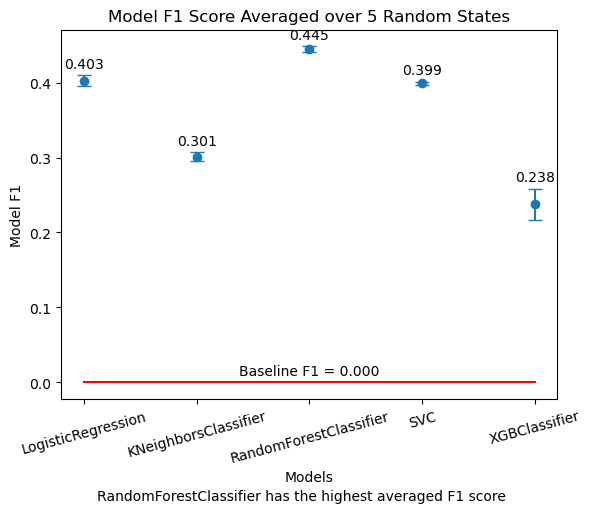

In [ ]:
# Summarizing performance of ML models
df_list = [lr_df, knn_df, rfc_df, svc_df, xgb_df]
df_names = [i['model_string'].iloc[0] for i in df_list]
test_f1_means = [np.average(i['test_f1']) for i in df_list]
test_f1_stdevs = [np.std(i['test_f1']) for i in df_list]

from matplotlib import pyplot as plt
fig = plt.figure()
plt.errorbar(df_names, test_score_means, yerr=test_score_stdevs, fmt='o', capsize=5, label = "model F1 score")
plt.plot(baseline_f1_array, color = 'red', label = "baseline F1")
plt.xlabel("Models")
plt.ylabel("Model F1")
plt.xticks(rotation = 15)
plt.title("Model F1 Score Averaged over 5 Random States")
plt.figtext(.5, -0.1, "RandomForestClassifier has the highest averaged F1 score", wrap = True, horizontalalignment = 'center')
#plt.legend(loc = 'center')

for i in range(len(test_f1_means)):
    plt.text(df_names[i], test_f1_means[i] + test_f1_stdevs[i] + 0.01, f'{test_f1_means[i]:.3f}', ha='center')
plt.text(df_names[2], baseline_f1_array[0]+0.01, f"Baseline F1 = {baseline_f1_array[0]:.3f}", ha = 'center')
plt.savefig('../figures/model_f1_plot.png',dpi = 300, bbox_inches='tight')
plt.show()

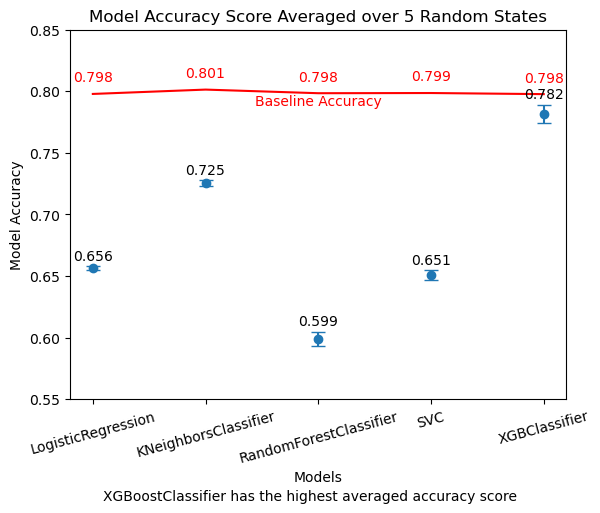

In [238]:
test_accuracy_means = [np.average(i['test_accuracy']) for i in df_list]
test_accuracy_stdevs = [np.std(i['test_accuracy']) for i in df_list]
# baseline_accuracy_array

fig = plt.figure()
plt.errorbar(df_names, test_accuracy_means, yerr=test_accuracy_stdevs, fmt='o', capsize=5, label = "model accuracy score")
plt.plot(baseline_accuracy_array, color = 'red', label = "baseline accuracy")
plt.xlabel("Models")
plt.ylabel("Model Accuracy")
plt.xticks(rotation = 15)
plt.title("Model Accuracy Score Averaged over 5 Random States")
plt.ylim([0.55,0.85])
plt.figtext(.5, -0.1, "XGBoostClassifier has the highest averaged accuracy score", wrap = True, horizontalalignment = 'center')
#plt.legend(loc = 'center')
for i in range(len(test_accuracy_means)):
    plt.text(df_names[i], test_accuracy_means[i] + test_accuracy_stdevs[i] + 0.005, f'{test_accuracy_means[i]:.3f}', ha='center')
    plt.text(df_names[i], baseline_accuracy_array[i] + np.std(baseline_accuracy_array[i]) + 0.01, f'{baseline_accuracy_array[i]:.3f}', \
             ha='center', color='red')
plt.text(df_names[2], baseline_accuracy_array[2] - 0.01, f'Baseline Accuracy', ha='center', color='red')
plt.savefig('../figures/model_accuracy_plot.png',dpi = 300, bbox_inches='tight')
plt.show()

Our RandomForestClassifier has the highest averaged F1 score at 44%, and our XGBoost Classifier has the lowest at 24%. Standard deviations were low across the board, likely due to our KFold Cross Validation, with the exception of XGBoost which has a notably large standard deviation compared to other models at 0.02. Compared to our baseline F1 of 0, our models are significantly better.

That being said, when evaluating accuracy, the results are inverted. XGBoost has the highest accuracy at 78% and RandomForestClassifier has the lowest at 60%. That being said, all of our models' accuracies are worse than the baseline accuracy of 80%.

Let's use one of our RandomForestClassifier models for a confusion matrix.

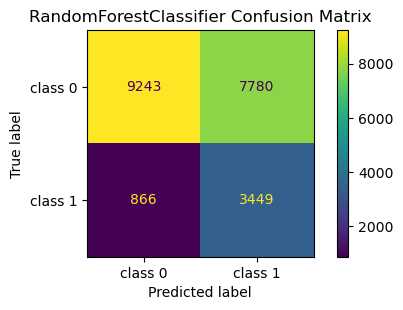


F1 score: 0.44377251672671125
Baseline F1 score: 0.0

Accuracy score: 0.5948073858843378
Baseline Accuracy score: 0.7977786109288593


In [304]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, fbeta_score, accuracy_score

_, X_test, _, y_test, groups_trainval = trainval_test(X_firstprep, y, 0)

model = rfc_df.iloc[0]['grid']
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
fig, ax = plt.subplots(figsize=(5,3))
disp.plot(ax=ax)
plt.tight_layout()
plt.title("RandomForestClassifier Confusion Matrix")
plt.savefig('../figures/rfc_cmatrix.png',dpi = 300, bbox_inches='tight')
plt.show()

baseline_arr = np.full(len(y_test), False)
print()
print(
f"F1 score: {fbeta_score(y_test, y_pred, beta = 1)}\n\
Baseline F1 score: {fbeta_score(y_test, baseline_arr, beta = 1)}\n\n\
Accuracy score: {accuracy_score(y_test, y_pred)}\n\
Baseline Accuracy score: {accuracy_score(y_test, baseline_arr)}")

Looks like the our model isn't purely predicting class 1 or 0. It's doing a good job predicting True Negatives, but it's False Positive Rate is extremely high. The F1 score is better than the baseline, but at 0.46 it's still not great. 

### Global feature importances

1. Perturbation feature importance
2. XGBoost-specific metrics
3. Linear Model Coefficient Weights
4. SHAP values

In [240]:
# Permutation Importance
from sklearn.inspection import permutation_importance
model = rfc_df['model'].iloc[0]
result = permutation_importance(model , X_train_prep, y_train, n_repeats=10, random_state=0, n_jobs = -1)
feature_names = X_train_prep.columns

top_features_ind = np.argsort(result.importances_mean)[::-1][0:10]
top_means = result.importances_mean[top_features_ind]
top_means_std = result.importances_std[top_features_ind]
top_feature_names = feature_names[top_features_ind]
importances = pd.Series(top_means, index = top_feature_names)

In [290]:
from textwrap import wrap
import io
text = ""
for line in range(len(importances)):
    text = text + (f'"{importances.index[line]}" {importances.values[line]}\n')
text_df = pd.read_csv(io.StringIO(text), delim_whitespace=True, header = None).rename(columns = {0: 'Feature', 1:'Importance'})
text_df

C:\Users\DWang\AppData\Local\Temp\ipykernel_15372\3537696289.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  text_df = pd.read_csv(io.StringIO(text), delim_whitespace=True, header = None).rename(columns = {0: 'Feature', 1:'Importance'})


,Feature,Importance
0,std__remainder__DateDiff,0.133723
1,minmax__remainder__Age,0.032634
2,remainder__remainder__SMS_received,0.016276
3,remainder__ord__SchedMonth,0.003702
4,remainder__ord__SchedDayOfWeek,0.003474
5,remainder__remainder__Scholarship,0.002470
6,remainder__ord__ApptMonth,0.002354
7,remainder__ord__ApptDayOfWeek,0.002141
8,remainder__remainder__Gender,0.001751
9,remainder__onehot__Neighbourhood_FORTE SÃO JOÃO,0.001544


C:\Users\DWang\AppData\Local\Temp\ipykernel_15372\530759292.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  text_df = pd.read_csv(io.StringIO(text), delim_whitespace=True, header = None).rename(columns = {0: 'Feature', 1:'Importance'})


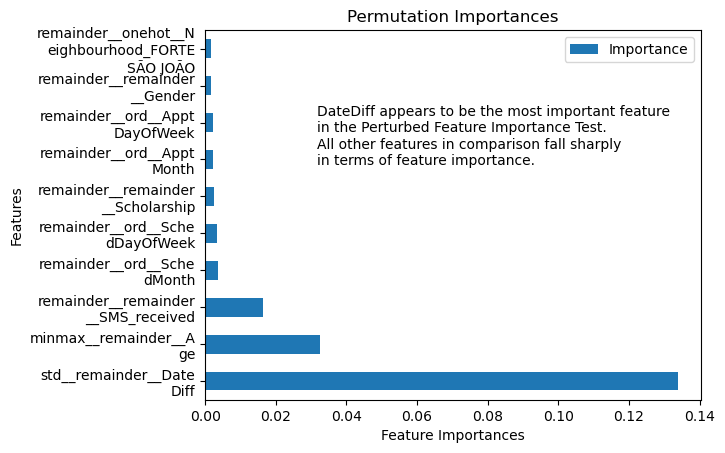

In [296]:
from textwrap import wrap
import io
text = ""
for line in range(len(importances)):
    text = text + (f'"{importances.index[line]}" {importances.values[line]}\n')
text_df = pd.read_csv(io.StringIO(text), delim_whitespace=True, header = None).rename(columns = {0: 'Feature', 1:'Importance'})

labels = [ '\n'.join(wrap(l, 20)) for l in text_df.Feature]

ax = text_df.plot.barh()
ax.set_yticklabels(labels)
plt.title("Permutation Importances")
plt.ylabel("Features", wrap = True)
#plt.xticks(rotation=90)
plt.xlabel("Feature Importances")
plt.figtext(0.3, 0.6, "DateDiff appears to be the most important feature \nin the Perturbed Feature Importance Test. \nAll other features in comparison fall sharply \nin terms of feature importance.")
plt.savefig('../figures/feature_importance_perturbation.png',dpi = 300, bbox_inches='tight')
plt.show()

In [317]:
# Least important? 
# Permutation Importance
from sklearn.inspection import permutation_importance
model = rfc_df['model'].iloc[0]
result = permutation_importance(model , X_train_prep, y_train, n_repeats=10, random_state=0, n_jobs = -1)

In [320]:
feature_names = X_train_prep.columns

bot_features_ind = np.argsort(result.importances_mean)[::1][0:10]
bot_means = result.importances_mean[bot_features_ind]
bot_means_std = result.importances_std[bot_features_ind]
bot_feature_names = feature_names[bot_features_ind]
importances = pd.Series(top_means, index = bot_feature_names)

C:\Users\DWang\AppData\Local\Temp\ipykernel_15372\1297080491.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  text_df = pd.read_csv(io.StringIO(text), delim_whitespace=True, header = None).rename(columns = {0: 'Feature', 1:'Importance'})


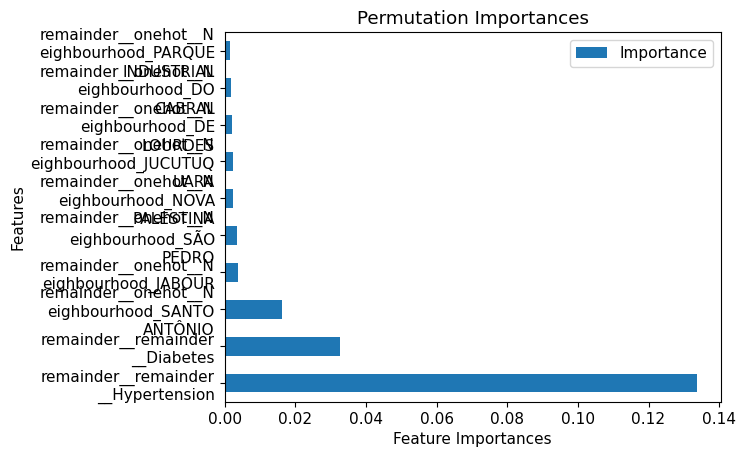

In [321]:
text = ""
for line in range(len(importances)):
    text = text + (f'"{importances.index[line]}" {importances.values[line]}\n')
text_df = pd.read_csv(io.StringIO(text), delim_whitespace=True, header = None).rename(columns = {0: 'Feature', 1:'Importance'})

labels = [ '\n'.join(wrap(l, 20)) for l in text_df.Feature]

ax = text_df.plot.barh()
ax.set_yticklabels(labels)
plt.title("Permutation Importances")
plt.ylabel("Features", wrap = True)
#plt.xticks(rotation=90)
plt.xlabel("Feature Importances")
plt.show()

In [251]:
# RFC Gini Importances
# Built-in feature importance (Gini Importance)
model = rfc_df['model'].iloc[0]
gini_importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': gini_importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df.iloc[:10])

                                           Feature  Gini Importance
1                         std__remainder__DateDiff         0.616190
0                           minmax__remainder__Age         0.121583
5                       remainder__ord__SchedMonth         0.059756
93              remainder__remainder__SMS_received         0.029742
3                   remainder__ord__SchedDayOfWeek         0.019358
2                    remainder__ord__ApptDayOfWeek         0.015934
87                    remainder__remainder__Gender         0.011561
4                        remainder__ord__ApptMonth         0.008278
76  remainder__onehot__Neighbourhood_SANTOS DUMONT         0.007260
89              remainder__remainder__Hypertension         0.007244


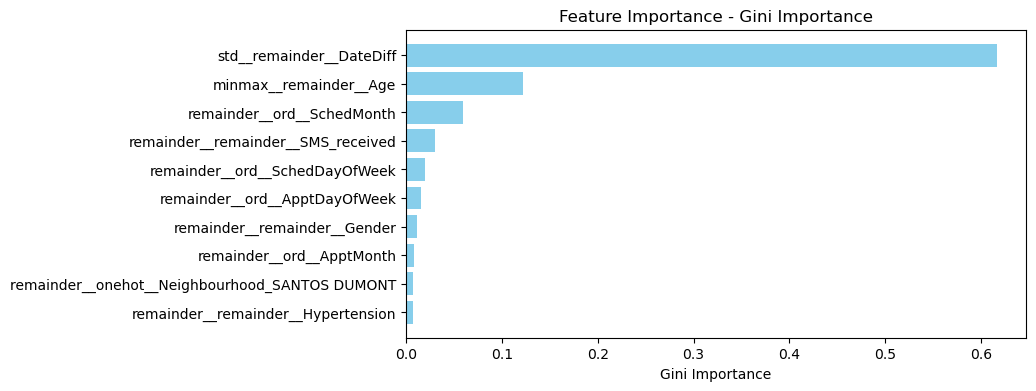

In [255]:
 #Create a bar plot for feature importance
top10_gini = feature_imp_df.iloc[:10]
plt.figure(figsize=(8, 4))
plt.barh(top10_gini['Feature'], top10_gini['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.savefig(f'../figures/feature_importance_rfc_gini.png',dpi = 300, bbox_inches='tight')
plt.show()

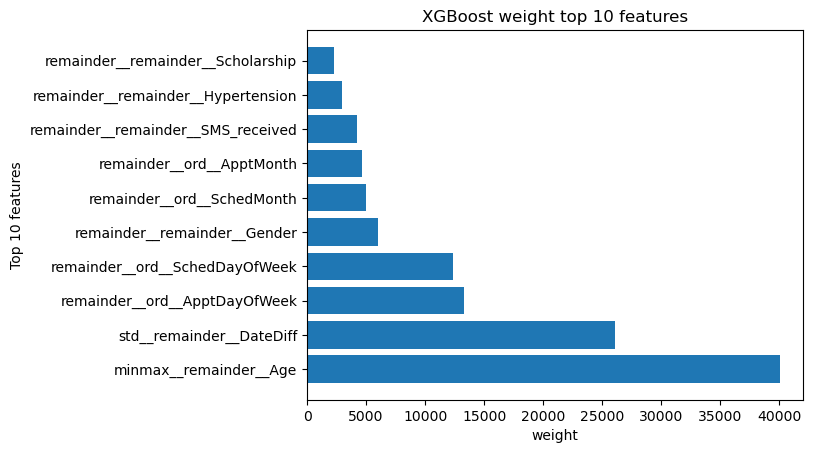

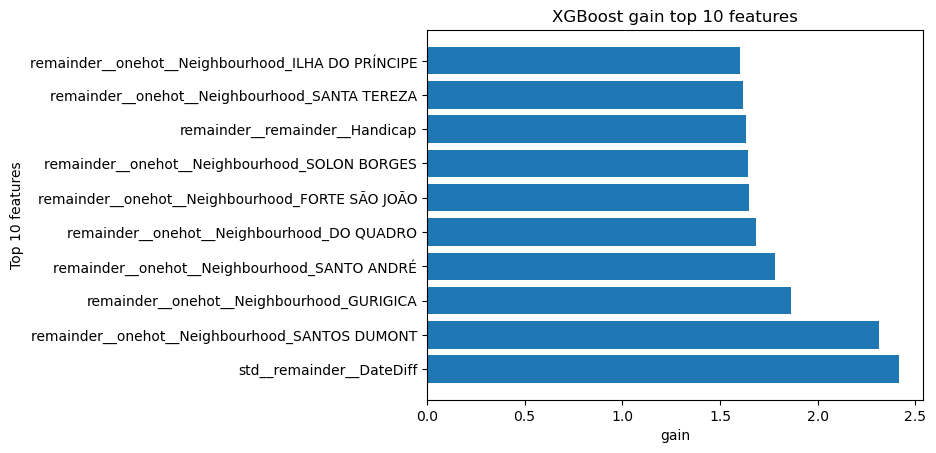

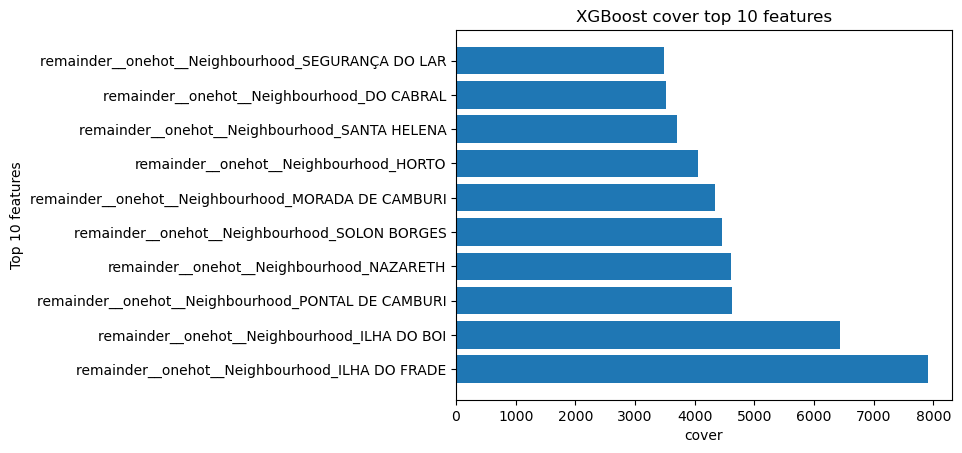

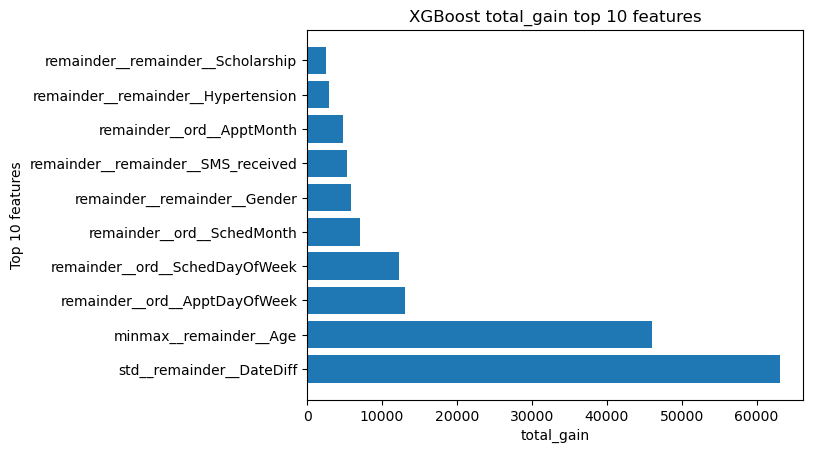

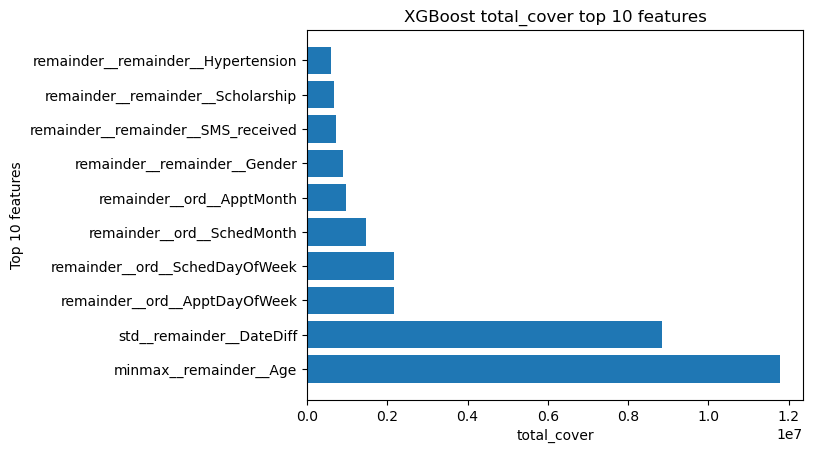

In [242]:
# XGBoost metrics
model = xgb_df['model'].iloc[0]
def xgb_metrics(importance_type, xgb_model):
    dict = xgb_model.get_booster().get_score(importance_type= importance_type)
    # get top 10 scores
    top_keys = sorted(dict, key = dict.get, reverse=True)[0:10]
    top_vals = [dict[w] for w in top_keys]

    # plot features + values
    from matplotlib import pyplot as plt
    plt.subplot()
    plt.barh(top_keys, top_vals)
    plt.xlabel(importance_type)
    plt.ylabel("Top 10 features")
    plt.title(f"XGBoost {importance_type} top 10 features")
    plt.savefig(f'../figures/feature_importance_xgb_{importance_type}.png',dpi = 300, bbox_inches='tight')
    plt.show()
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for type in importance_types: xgb_metrics(type, model)

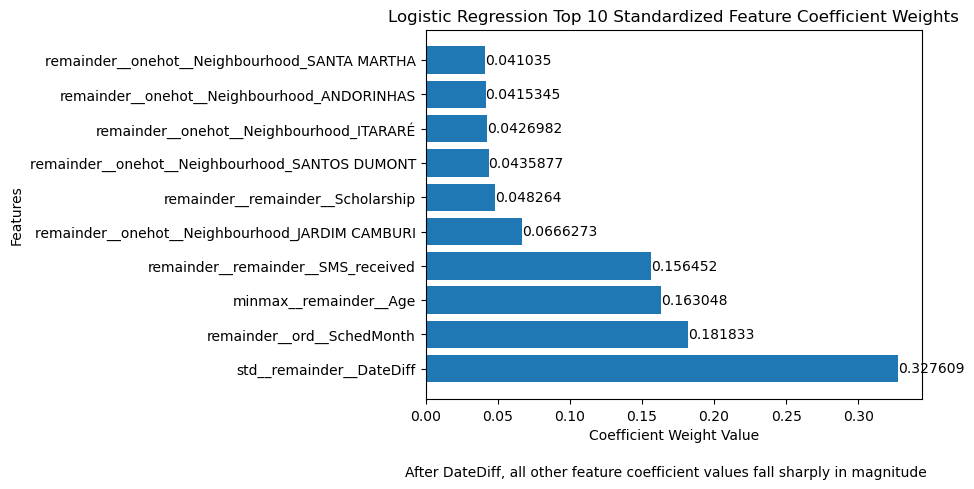

In [243]:
# Linear Coefficients
lr_ind = np.argsort(np.abs(lr_df['model'].iloc[0].coef_)[0])[::-1][0:10]
lr_columns = X_train_prep.columns[lr_ind]
lr_vals = np.sort(np.abs(lr_df['model'].iloc[0].coef_)[0])[::-1][0:10]
lr_coefficients_df = pd.DataFrame(list(zip(lr_columns, lr_vals)), columns = ['Column', 'Coefficient Weight'])

fig, ax = plt.subplots()
bars = ax.barh(lr_coefficients_df['Column'], lr_coefficients_df['Coefficient Weight'])
ax.bar_label(bars)
ax.set_title("Logistic Regression Top 10 Standardized Feature Coefficient Weights")
ax.set_ylabel("Features")
ax.set_xlabel("Coefficient Weight Value")
plt.figtext(0.5, -0.05, "After DateDiff, all other feature coefficient values fall sharply in magnitude", horizontalalignment = 'center', wrap = True)
plt.savefig('../figures/feature_importance_linearmodelweights.png',dpi = 300, bbox_inches='tight')
plt.show()

In [244]:
# SHAP
import shap
model = rfc_df['model'].iloc[0]
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(model)
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_prep[:1000])
print(X_test_prep[:1000].shape)
print(np.shape(shap_values))

(1000, 94)
(1000, 94, 2)


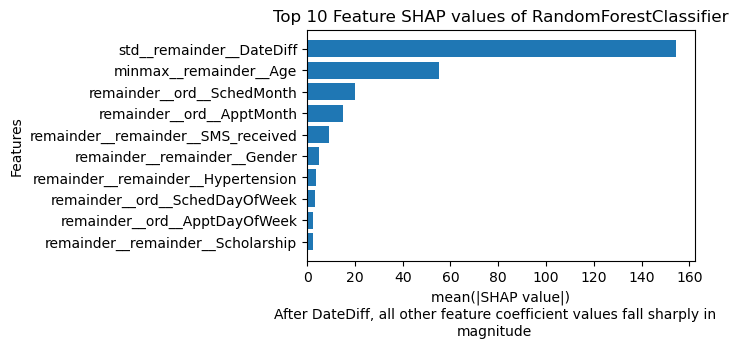

In [245]:
shap_summary = np.sum(np.abs(shap_values[:,:,1]),axis=0) # same shape as the number of features
indcs = np.argsort(shap_summary)

plt.figure(figsize=(5,3))
plt.barh(feature_names[indcs[-10:]],shap_summary[indcs[-10:]])
plt.title("Top 10 Feature SHAP values of RandomForestClassifier")
plt.ylabel("Features")
plt.xlabel('mean(|SHAP value|)')
plt.figtext(0.5, -0.13, "After DateDiff, all other feature coefficient values fall sharply in magnitude", horizontalalignment = 'center', wrap = True)
plt.savefig('../figures/feature_importance_shap.png',dpi = 300, bbox_inches='tight')
plt.show()

### Local Feature Importance with SHAP

0.4997439467255668


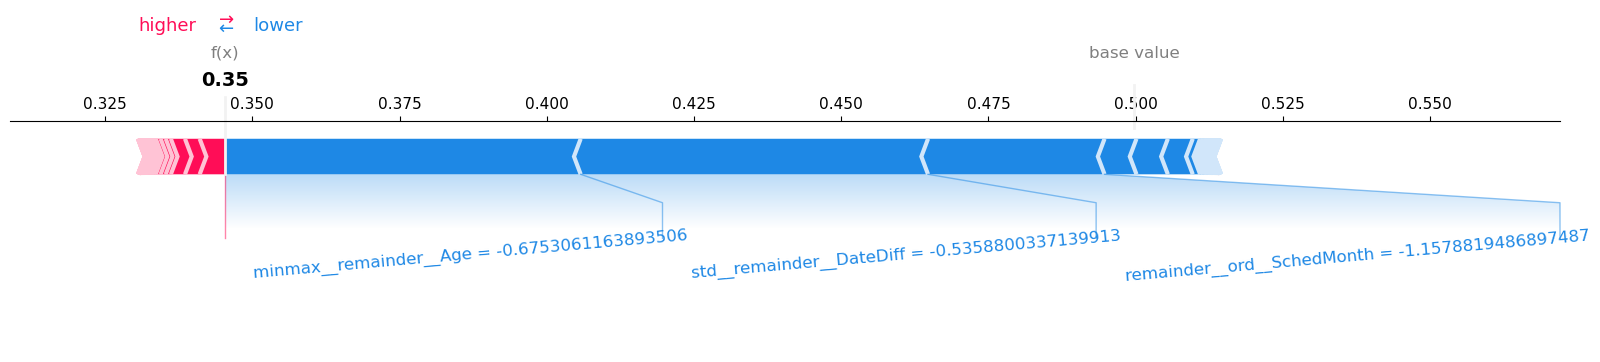

In [322]:
index = 1 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions! Change indices to 1 if you want to explain class 1 predictions!

shap_output = shap.force_plot(explainer.expected_value[0], shap_values[index,:,0], features = X_test_prep.iloc[index,:],feature_names = feature_names\
                              ,show = False, matplotlib = True, text_rotation = 5)
plt.savefig(f'../figures/local_feature_importance_shap{index}.png',dpi = 300, bbox_inches='tight')
#shap.save_html('../figures/local_feature_importance_shap1.html', shap_output)
shap_output

0.35 calculated probability to be class 0 --> Model predicted True, i.e. predicted class 1 (Showed Up == False)

0.4997439467255668


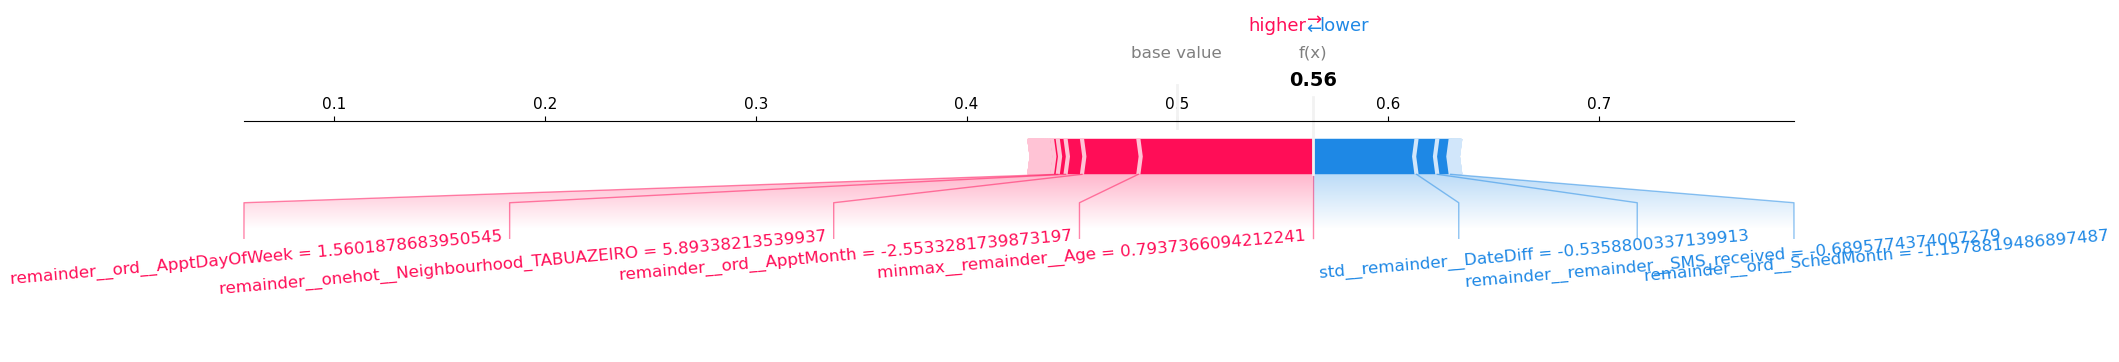

In [323]:
index = 42 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions! Change indices to 1 if you want to explain class 1 predictions!

shap_output = shap.force_plot(explainer.expected_value[0], shap_values[index,:,0], features = X_test_prep.iloc[index,:],feature_names = feature_names\
                              ,show = False, matplotlib = True, text_rotation = 5)
plt.savefig(f'../figures/local_feature_importance_shap{index}.png',dpi = 300, bbox_inches='tight')
shap_output

0.4997439467255668


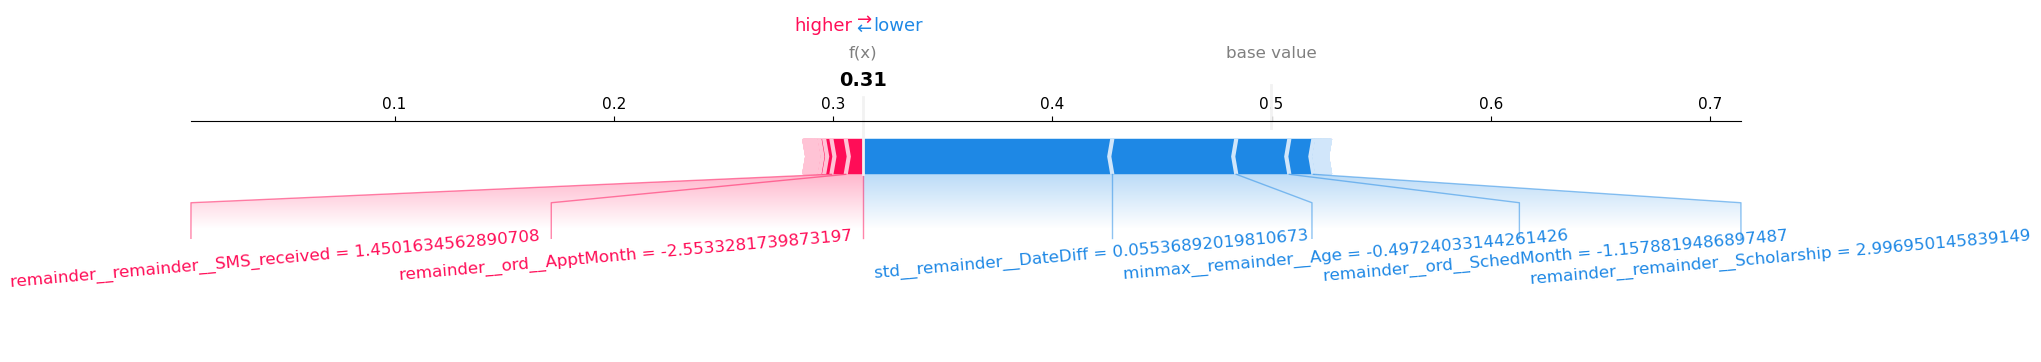

In [324]:
index = 96 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions! Change indices to 1 if you want to explain class 1 predictions!

shap_output = shap.force_plot(explainer.expected_value[0], shap_values[index,:,0], features = X_test_prep.iloc[index,:],feature_names = feature_names\
                              ,show = False, matplotlib = True, text_rotation = 5)
plt.savefig(f'../figures/local_feature_importance_shap{index}.png',dpi = 300, bbox_inches='tight')
shap_output